# **Proyecto 3 c2**

* Daniel Bernal

El siguiente proyecto tiene como fin seguir el procedimiento que se utilizo en el "Proyecto 2 c2" donde se a partir de un set de datos se quiere responder ciertas preguntas claves.

El conjunto de datos a analizar en este proyecto es la información sobre las viviendas en la ciudad de Bogotá-Colombia. A lo largo de este proyecto se realiza una limpieza de datos, analisis exploratorio, transformacion de datos, generacion y evaluacion de los modelos y por ultimo el planteamiento de las preguntas claves y la respuesta a las mismas a traves de mapas y diferentes herrmaientas.

In [ ]:
import pandas as pd
import json
import requests
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Datos

In [ ]:
#url = "https://www.dropbox.com/scl/fi/bxj03wii0ez50ixe9q5yv/builker.scrapy_bogota_apartmentsV1.2.0_august_1.json?rlkey=btg69ut2biha7xd1j5llk0gj4&dl=1" # V1.2.0 August 1 2023
# url = "https://www.dropbox.com/scl/fi/ar2d96q96c8vqxvrpyr9i/builker.scrapy_bogota_apartmentsV1.2.2_september_1_2023.json?rlkey=w93hngjdaiosuhjcr1zsktomn&dl=1" # V1.2.2 September 1 2023

#Se utiliza este archivo JSON ya que desglosa la informacion de la descripcion implementando nuevas columnas que pueden ser relevantes
url = "https://github.com/builker-col/bogota-apartments/releases/download/v2.0.0-august.2-2024/processed_v2.0.0_august_2_2024.json" # V1.3.0 October 1 2023
response = requests.get(url)

# Guarde el archivo JSON en el directorio de trabajo actual
with open("processed_v2.0.0_august_2_2024.json", 'wb') as f:
    f.write(response.content)

In [ ]:
# Cargar el archivo JSON que has guardado
with open("processed_v2.0.0_august_2_2024.json", 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data)

# Mostrar las primeras filas del DataFrame
df.head()

codigo tipo_propiedad tipo_operacion  precio_venta  area  habitaciones  \
0  4133491    APARTAMENTO          VENTA   339000000.0  76.0           3.0   
1  3889852    APARTAMENTO          VENTA   223000000.0  63.0           3.0   
2  4386770    APARTAMENTO          VENTA   440898168.0  54.0           3.0   
3  4210060    APARTAMENTO          VENTA   158000000.0  43.0           2.0   
4  4063762    APARTAMENTO          VENTA   222800000.0  48.0           3.0   

   banos  administracion  parqueaderos               sector  ...  \
0    2.0        300000.0           1.0             BRITALIA  ...   
1    2.0             NaN           0.0  SAN CRISTOBAL NORTE  ...   
2    2.0        305000.0           0.0            LA SABANA  ...   
3    2.0        106600.0           0.0            TIBABUYES  ...   
4    2.0        151000.0           0.0             VERBENAL  ...   

   jacuzzi.$numberDouble chimenea.$numberDouble  \
0                    NaN                    NaN   
1                    NaN                    NaN   
2                    NaN                    NaN   
3                    NaN                    NaN   
4                    NaN                    NaN   

   permite_mascotas.$numberDouble  gimnasio.$numberDouble  \
0                             NaN                     NaN   
1                             NaN                     NaN   
2                             NaN                     NaN   
3                             NaN                     NaN   
4                             NaN                     NaN   

  ascensor.$numberDouble conjunto_cerrado.$numberDouble piscina.$numberDouble  \
0                    NaN                            NaN                   NaN   
1                    NaN                            NaN                   NaN   
2                    NaN                            NaN                   NaN   
3                    NaN                            NaN                   NaN   
4                    NaN                            NaN                   NaN   

  salon_comunal.$numberDouble terraza.$numberDouble vigilancia.$numberDouble  
0                         NaN                   NaN                      NaN  
1                         NaN                   NaN                      NaN  
2                         NaN                   NaN                      NaN  
3                         NaN                   NaN                      NaN  
4                         NaN                   NaN                      NaN  

[5 rows x 74 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43013 entries, 0 to 43012
Data columns (total 74 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   codigo                          43013 non-null  object 
 1   tipo_propiedad                  43013 non-null  object 
 2   tipo_operacion                  43013 non-null  object 
 3   precio_venta                    27584 non-null  float64
 4   area                            43013 non-null  float64
 5   habitaciones                    43012 non-null  float64
 6   banos                           43012 non-null  float64
 7   administracion                  35088 non-null  float64
 8   parqueaderos                    43012 non-null  float64
 9   sector                          41372 non-null  object 
 10  estrato                         43012 non-null  float64
 11  antiguedad                      43003 non-null  object 
 12  latitud                         

In [ ]:
#Se eliminan las siguientes por representar poca relevancia
df.drop('descripcion', axis=1, inplace=True)
df.drop('datetime', axis=1, inplace=True)
df.drop('last_view', axis=1, inplace=True)
df.drop('coords_modified', axis=1, inplace=True)
df.drop('url', axis=1, inplace=True)
df.drop('timeline', axis = 1, inplace= True)

In [ ]:
#Debido al metodo de importacion de los datos se encontro que se duplicaban columnas y estas en su nombre se encontraban el signo $
#Dichas columnas no presentan informacion de importancia y estan llenas de NaN por lo tanto se eliminan
columns_to_drop = [col for col in df.columns if '$' in col]
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43013 entries, 0 to 43012
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   codigo                   43013 non-null  object 
 1   tipo_propiedad           43013 non-null  object 
 2   tipo_operacion           43013 non-null  object 
 3   precio_venta             27584 non-null  float64
 4   area                     43013 non-null  float64
 5   habitaciones             43012 non-null  float64
 6   banos                    43012 non-null  float64
 7   administracion           35088 non-null  float64
 8   parqueaderos             43012 non-null  float64
 9   sector                   41372 non-null  object 
 10  estrato                  43012 non-null  float64
 11  antiguedad               43003 non-null  object 
 12  latitud                  43013 non-null  float64
 13  longitud                 43013 non-null  float64
 14  direccion             

In [ ]:
#Verificamos si la columna codigo tiene elementos repetidos
repetidos = df['codigo'].duplicated()

# Muestra las filas duplicadas
duplicados_df = df[repetidos]

# Para contar cuántos duplicados hay
num_duplicados = duplicados_df.shape[0]
print(f"Número de duplicados: {num_duplicados}")

Número de duplicados: 0


In [ ]:
# Se coloca la columna codigo como index para relacionar cada vivienda por su codigo inicial
df = df.set_index('codigo')

df

tipo_propiedad tipo_operacion  precio_venta    area  habitaciones  \
codigo                                                                        
4133491      APARTAMENTO          VENTA  3.390000e+08   76.00           3.0   
3889852      APARTAMENTO          VENTA  2.230000e+08   63.00           3.0   
4386770      APARTAMENTO          VENTA  4.408982e+08   54.00           3.0   
4210060      APARTAMENTO          VENTA  1.580000e+08   43.00           2.0   
4063762      APARTAMENTO          VENTA  2.228000e+08   48.00           3.0   
...                  ...            ...           ...     ...           ...   
4323513      APARTAMENTO          VENTA  1.900000e+08   49.00           3.0   
4345085      APARTAMENTO          VENTA  3.220000e+08   66.00           3.0   
MC5206960    APARTAMENTO          VENTA  3.300000e+08   90.00           3.0   
MC5203688    APARTAMENTO          VENTA  1.280000e+09  157.00           3.0   
MC4721977    APARTAMENTO          VENTA  4.980000e+08   84.34           3.0   

           banos  administracion  parqueaderos               sector  estrato  \
codigo                                                                         
4133491      2.0        300000.0           1.0             BRITALIA      3.0   
3889852      2.0             NaN           0.0  SAN CRISTOBAL NORTE      3.0   
4386770      2.0        305000.0           0.0            LA SABANA      3.0   
4210060      2.0        106600.0           0.0            TIBABUYES      2.0   
4063762      2.0        151000.0           0.0             VERBENAL      3.0   
...          ...             ...           ...                  ...      ...   
4323513      2.0        204624.0           0.0                 SUBA      2.0   
4345085      2.0        277400.0           1.0            EL RINCON      4.0   
MC5206960    2.0        112000.0           0.0           LA SOLEDAD      4.0   
MC5203688    3.0       1050000.0           3.0        SANTA BARBARA      6.0   
MC4721977    2.0        287000.0           1.0              KENNEDY      4.0   

           ...                        barrio  estacion_tm_cercana  \
codigo     ...                                                      
4133491    ...                URB. PICADELLY  Toberin - Foundever   
3889852    ...    BARRANCAS PERLAS DEL NORTE              Mazurén   
4386770    ...                 SAN VICTORINO         De La Sabana   
4210060    ...                LA ESTRELLA II          Portal Suba   
4063762    ...            HORIZONTES USAQUEN             Terminal   
...        ...                           ...                  ...   
4323513    ...                   URB. OVIEDO          Portal Suba   
4345085    ...  LOS TEJARES DE SUBA (PREDIO)           La Campiña   
MC5206960  ...                  LAS AMERICAS         AV. ElDorado   
MC5203688  ...                S.C. SAN NORTE            Calle 127   
MC4721977  ...       HIPOTECHO OCCIDENTAL II             Marsella   

           distancia_estacion_tm_m is_cerca_estacion_tm  \
codigo                                                    
4133491                    1142.45                    0   
3889852                    2384.89                    0   
4386770                     232.22                    1   
4210060                    2275.08                    0   
4063762                    2099.16                    0   
...                            ...                  ...   
4323513                    1712.71                    0   
4345085                     120.16                    1   
MC5206960                    33.21                    1   
MC5203688                  3005.88                    0   
MC4721977                  1022.07                    0   

                                              parque_cercano  \
codigo                                                         
4133491    PARQUE VECINAL DESARROLLO CANTALEJO URBANIZACI...   
3889852                             PARQUE ZONAL ALTA BLANCA   
4386770            

In [ ]:
#Se visualiza el tipo de dato para su respectivo cambio (castearlo)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43013 entries, 4133491 to MC4721977
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tipo_propiedad           43013 non-null  object 
 1   tipo_operacion           43013 non-null  object 
 2   precio_venta             27584 non-null  float64
 3   area                     43013 non-null  float64
 4   habitaciones             43012 non-null  float64
 5   banos                    43012 non-null  float64
 6   administracion           35088 non-null  float64
 7   parqueaderos             43012 non-null  float64
 8   sector                   41372 non-null  object 
 9   estrato                  43012 non-null  float64
 10  antiguedad               43003 non-null  object 
 11  latitud                  43013 non-null  float64
 12  longitud                 43013 non-null  float64
 13  direccion                794 non-null    object 
 14  website          

In [ ]:
# Verificar las categorias de cada columna
df['tipo_propiedad'] = df['tipo_propiedad'].apply(lambda x: json.dumps(x) if isinstance(x, dict) else x)

# Se utiliza la funcion unique()
unique_direcciones = df['tipo_propiedad'].unique()
print(unique_direcciones)

['APARTAMENTO' 'CASA CON CONJUNTO CERRADO' 'CASA']


In [ ]:
# Funcion para extraer la parte numerica donde los valores numericos los coloca a float de '$numberLong'
def extract_number(value):
    if isinstance(value, dict) and '$numberLong' in value:
        try:
            return int(value['$numberLong'])
        except (ValueError, TypeError):
            return None
    return value

# Aplicacion de funcion a columnas que lo necesitan
df['precio_venta'] = df['precio_venta'].apply(extract_number)
df['precio_arriendo'] = df['precio_arriendo'].apply(extract_number)
df['administracion'] = df['administracion'].apply(extract_number)
#df['precio_venta_anterior'] = df['precio_venta_anterior'].apply(extract_number)
#df['precio_arriendo_anterior'] = df['precio_arriendo_anterior'].apply(extract_number)

# Funcion para extraer la parte nan, los valores numericos los coloca a float de '$numberLong' o '$numberDouble
def extract_number_or_nan(value):
    if isinstance(value, dict):
        if '$numberLong' in value:
            try:
                return int(value['$numberLong'])
            except (ValueError, TypeError):
                return None
        elif '$numberDouble' in value:
            if value['$numberDouble'] == 'NaN':
                return float('nan')  # Convertir a NaN
            else:
                try:
                    return float(value['$numberDouble'])
                except (ValueError, TypeError):
                    return None
    return value

# Aplicacion de funcion a columnas que lo necesitan
df['precio_venta'] = df['precio_venta'].apply(extract_number_or_nan)
df['precio_arriendo'] = df['precio_arriendo'].apply(extract_number_or_nan)
df['administracion'] = df['administracion'].apply(extract_number_or_nan)
df['estado'] = df['estado'].apply(extract_number_or_nan)
#df['fecha_actualizacion_precio_venta'] = df['fecha_actualizacion_precio_venta'].apply(extract_number_or_nan)
#df['fecha_actualizacion_precio_arriendo'] = df['fecha_actualizacion_precio_arriendo'].apply(extract_number_or_nan)
#df['precio_venta_anterior'] = df['precio_venta_anterior'].apply(extract_number_or_nan)
#df['precio_arriendo_anterior'] = df['precio_arriendo_anterior'].apply(extract_number_or_nan)
df['direccion']  = df['direccion'].apply(extract_number_or_nan)
df['jacuzzi'] = df['jacuzzi'].apply(extract_number_or_nan)
#df['piso'] = df['piso'].apply(extract_number_or_nan)
df['chimenea']= df['chimenea'].apply(extract_number_or_nan)
df['permite_mascotas'] = df['permite_mascotas'].apply(extract_number_or_nan)
df['gimnasio'] = df['gimnasio'].apply(extract_number_or_nan)
df['ascensor'] = df['ascensor'].apply(extract_number_or_nan)
df['conjunto_cerrado']= df['conjunto_cerrado'].apply(extract_number_or_nan)

# Función para convertir valores string de '$numberLong' o '$numberDouble' a null
def extract_number_or_null(value):
    if isinstance(value, dict):
        if '$numberLong' in value:
            try:
                return int(value['$numberLong'])
            except (ValueError, TypeError):
                return None
        elif '$numberDouble' in value:
            if value['$numberDouble'] == 'NaN':
                return None  # Cambia 'NaN' a None
            else:
                try:
                    return float(value['$numberDouble'])
                except (ValueError, TypeError):
                    return None
    return value

# Aplicacion de funcion a columnas que lo necesitan
df['barrio'] = df['barrio'].apply(extract_number_or_null)
df['direccion'] = df['direccion'].apply(extract_number_or_null)
df['antiguedad'] = df['antiguedad'].apply(extract_number_or_null)
df['website'] = df['website'].apply(extract_number_or_null)

In [ ]:
# Convierto los valores a numerico y con coerce coloco los valores a nan si no se puede convertir a numero
df['area'] = pd.to_numeric(df['area'], errors='coerce')
df['habitaciones'] = pd.to_numeric(df['habitaciones'], errors='coerce')
df['banos'] = pd.to_numeric(df['banos'], errors='coerce')
df['parqueaderos'] = pd.to_numeric(df['parqueaderos'], errors='coerce')
df['estrato'] = pd.to_numeric(df['estrato'], errors='coerce')

# Posteriormente, manejamos los valores como tipo float
df['area'] = df['area'].astype(float)
df['habitaciones'] = df['habitaciones'].astype(float)
df['banos'] = df['banos'].astype(float)
df['parqueaderos'] = df['parqueaderos'].astype(float)
df['estrato'] = df['estrato'].astype(float)

# Verificación de cambios realizado
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43013 entries, 4133491 to MC4721977
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tipo_propiedad           43013 non-null  object 
 1   tipo_operacion           43013 non-null  object 
 2   precio_venta             27584 non-null  float64
 3   area                     43013 non-null  float64
 4   habitaciones             43012 non-null  float64
 5   banos                    43012 non-null  float64
 6   administracion           35088 non-null  float64
 7   parqueaderos             43012 non-null  float64
 8   sector                   41372 non-null  object 
 9   estrato                  43012 non-null  float64
 10  antiguedad               43003 non-null  object 
 11  latitud                  43013 non-null  float64
 12  longitud                 43013 non-null  float64
 13  direccion                794 non-null    object 
 14  website          

In [ ]:
# Ser verifica otras columnas para ver sus categorias
cols = ['piscina', 'salon_comunal', 'terraza', 'vigilancia', 'parque_cercano', 'distancia_parque_m', 'is_cerca_parque']

for i in cols:
  print(df[i].unique())

[ 0.  1. nan]
[ 0. nan]
[ 0.  1. nan]
[ 0.  1. nan]
['PARQUE VECINAL DESARROLLO CANTALEJO URBANIZACIÓN CANTALEJO MANZANA B'
 'PARQUE ZONAL ALTA BLANCA' 'PARQUE METROPOLITANO TERCER MILENIO'
 'PARQUE ZONAL LA GAITANA' 'PARQUE VECINAL DESARROLLO VERBENAL I'
 'PARQUE VECINAL URBANIZACIÓN SANTIAGO DE ATALAYAS'
 'PARQUE VECINAL URBANIZACIÓN VALLE DE REFOUS'
 'PARQUE VECINAL CIUDADELA CAFAM ANTES URBANIZACIÓN PUERTO SOL'
 'PARQUE ZONAL CIUDAD MONTES'
 'PARQUE METROPOLITANO PLANTA DE TRATAMIENTO SALITRE'
 'PARQUE VECINAL SANTA CLARA'
 'PARQUE VECINAL URBANIZACIÓN CALLE 170 / ALAMEDA'
 'PARQUE VECINAL DESARROLLO ESTRELLA DEL NORTE'
 'PARQUE ZONAL CANAL EL VIRREY EL CHICO' 'PARQUE ZONAL SAN IGNACIO'
 'PARQUE VECINAL VILLA DE LOS SAUCES'
 'PARQUE VECINAL NUEVA URBANIZACIÓN EL CEDRITO'
 'PARQUE ZONAL VILLAS DE GRANADA' 'PARQUE ZONAL LA VIDA'
 'PARQUE ZONAL BELLAVISTA DINDALITO' 'PARQUE VECINAL PRIMAVERA'
 'PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) ENRIQUE OLAYA HERRERA (SECTOR HISTORICO)'
 'PAR

In [ ]:
#Se evidencia que salon comunal solo tiene una categoria por lo que se toma como irrelevante

df.drop('salon_comunal', axis=1, inplace=True)

In [ ]:
# Verificar las categorias de cada columna
df['estrato'] = df['estrato'].apply(lambda x: json.dumps(x) if isinstance(x, dict) else x)

# Se utiliza la funcion unique()
unique_direcciones = df['estrato'].unique()
print(unique_direcciones)

[ 3.  2.  4.  5.  1.  6. nan  0.]


In [ ]:
# Count elements per category in the 'tipo_propiedad' column
property_type_counts = df['tipo_propiedad'].value_counts()
property_type_counts

tipo_propiedad
APARTAMENTO                  42943
CASA CON CONJUNTO CERRADO       60
CASA                            10
Name: count, dtype: int64

In [ ]:
# Count elements per category in the 'tipo_propiedad' column
property_type_counts2 = df['website'].value_counts()
property_type_counts2

website
metrocuadrado.com    42217
habi.co                794
Name: count, dtype: int64

In [ ]:
#Se encuentra cantidad de elementos nulos
df.isnull().sum()

tipo_propiedad                 0
tipo_operacion                 0
precio_venta               15429
area                           0
habitaciones                   1
banos                          1
administracion              7925
parqueaderos                   1
sector                      1641
estrato                        1
antiguedad                    10
latitud                        0
longitud                       0
direccion                  42219
website                        2
jacuzzi                        2
chimenea                       2
permite_mascotas               2
gimnasio                       2
ascensor                       2
conjunto_cerrado               2
piscina                        2
terraza                        2
vigilancia                     2
localidad                      0
barrio                       193
estacion_tm_cercana            0
distancia_estacion_tm_m        0
is_cerca_estacion_tm           0
parque_cercano                 0
distancia_parque_m             0
is_cerca_parque                0
estado                       796
compañia                    4530
precio_arriendo            27184
dtype: int64

In [ ]:
#Se eliminan las columnas que presenten mas del 50% de datos nulos
#df.drop('closets', axis=1, inplace=True) #53%
#df.drop('fecha_actualizacion_precio_venta', axis=1, inplace=True) #94%
#df.drop('precio_venta_anterior', axis=1, inplace=True) #94%
#df.drop('fecha_actualizacion_precio_arriendo', axis=1, inplace=True) #96%
#df.drop('precio_arriendo_anterior', axis=1, inplace=True) #96%
df.drop('direccion', axis=1, inplace=True) #100%

In [ ]:
#Se considero que la columna website y compañia es irrelevante para las preguntas generadas
df.drop('website', axis=1, inplace=True)
df.drop('compañia', axis=1, inplace=True)

In [ ]:
#Al tener solo un solo estado, no varia en el tratamiento de datos, por lo tanto, se elimina
property_type_counts = df['estado'].value_counts()
property_type_counts

estado
USADO    41991
NUEVO      226
Name: count, dtype: int64

In [ ]:
#Dividimos los datos en train y test estableciendo el 20% de los datos para test
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#Verificamos el tamaño de los datos
print("Train size: {f}".format(f=train.shape[0]))
print("Test size: {t}".format(t=test.shape[0]))

Train size: 34410
Test size: 8603


In [ ]:
df

tipo_propiedad tipo_operacion  precio_venta    area  habitaciones  \
codigo                                                                        
4133491      APARTAMENTO          VENTA  3.390000e+08   76.00           3.0   
3889852      APARTAMENTO          VENTA  2.230000e+08   63.00           3.0   
4386770      APARTAMENTO          VENTA  4.408982e+08   54.00           3.0   
4210060      APARTAMENTO          VENTA  1.580000e+08   43.00           2.0   
4063762      APARTAMENTO          VENTA  2.228000e+08   48.00           3.0   
...                  ...            ...           ...     ...           ...   
4323513      APARTAMENTO          VENTA  1.900000e+08   49.00           3.0   
4345085      APARTAMENTO          VENTA  3.220000e+08   66.00           3.0   
MC5206960    APARTAMENTO          VENTA  3.300000e+08   90.00           3.0   
MC5203688    APARTAMENTO          VENTA  1.280000e+09  157.00           3.0   
MC4721977    APARTAMENTO          VENTA  4.980000e+08   84.34           3.0   

           banos  administracion  parqueaderos               sector  estrato  \
codigo                                                                         
4133491      2.0        300000.0           1.0             BRITALIA      3.0   
3889852      2.0             NaN           0.0  SAN CRISTOBAL NORTE      3.0   
4386770      2.0        305000.0           0.0            LA SABANA      3.0   
4210060      2.0        106600.0           0.0            TIBABUYES      2.0   
4063762      2.0        151000.0           0.0             VERBENAL      3.0   
...          ...             ...           ...                  ...      ...   
4323513      2.0        204624.0           0.0                 SUBA      2.0   
4345085      2.0        277400.0           1.0            EL RINCON      4.0   
MC5206960    2.0        112000.0           0.0           LA SOLEDAD      4.0   
MC5203688    3.0       1050000.0           3.0        SANTA BARBARA      6.0   
MC4721977    2.0        287000.0           1.0              KENNEDY      4.0   

           ...     localidad                        barrio  \
codigo     ...                                               
4133491    ...          SUBA                URB. PICADELLY   
3889852    ...       USAQUEN    BARRANCAS PERLAS DEL NORTE   
4386770    ...  LOS MARTIRES                 SAN VICTORINO   
4210060    ...          SUBA                LA ESTRELLA II   
4063762    ...       USAQUEN            HORIZONTES USAQUEN   
...        ...           ...                           ...   
4323513    ...          SUBA                   URB. OVIEDO   
4345085    ...          SUBA  LOS TEJARES DE SUBA (PREDIO)   
MC5206960  ...   TEUSAQUILLO                  LAS AMERICAS   
MC5203688  ...       USAQUEN                S.C. SAN NORTE   
MC4721977  ...       KENNEDY       HIPOTECHO OCCIDENTAL II   

           estacion_tm_cercana  distancia_estacion_tm_m  is_cerca_estacion_tm  \
codigo                                                                          
4133491    Toberin - Foundever                  1142.45                     0   
3889852                Mazurén                  2384.89                     0   
4386770           De La Sabana                   232.22                     1   
4210060            Portal Suba                  2275.08                     0   
4063762               Terminal                  2099.16                     0   
...                        ...                      ...                   ...   
4323513            Portal Suba                  1712.71                     0   
4345085             La Campiña                   120.16                     1   
MC5206960         AV. ElDorado                    33.21                     1   
MC5203688            Calle 127                  3005.88                     0   
MC4721977             Marsella                  1022.07                     0   

                                              parque_cercano  \
codigo          

In [ ]:
df['precio_venta'].max()

4250000000000.0

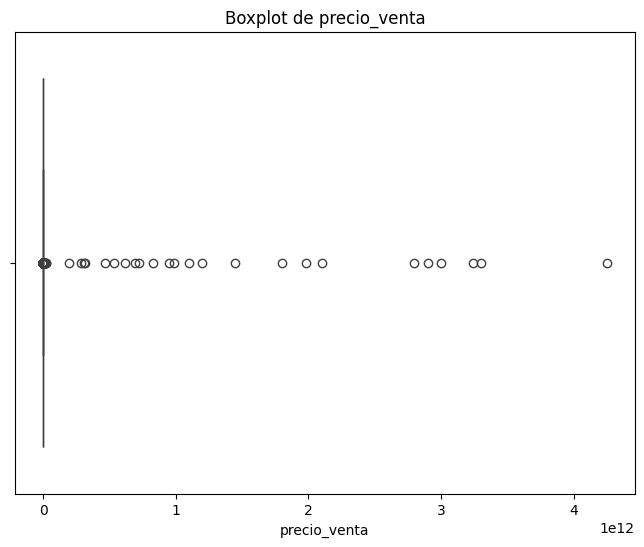

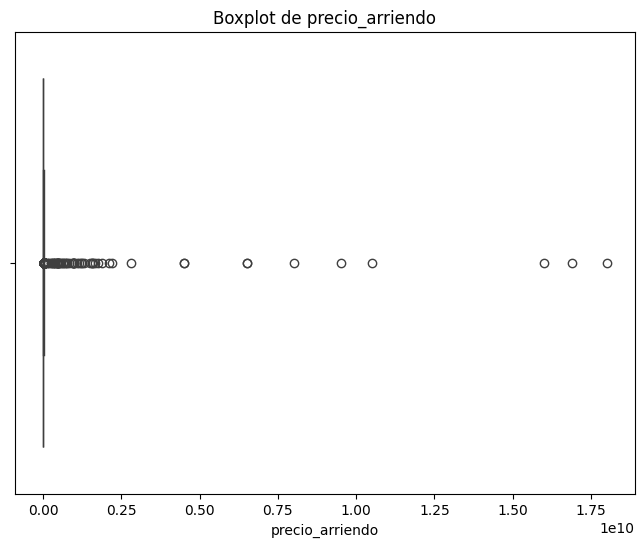

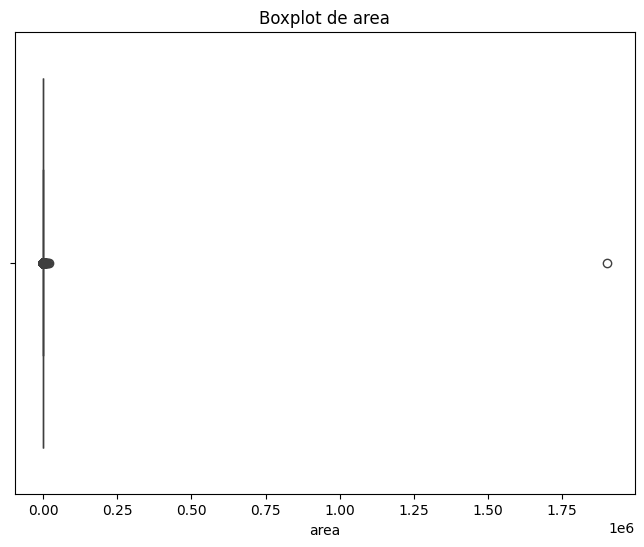

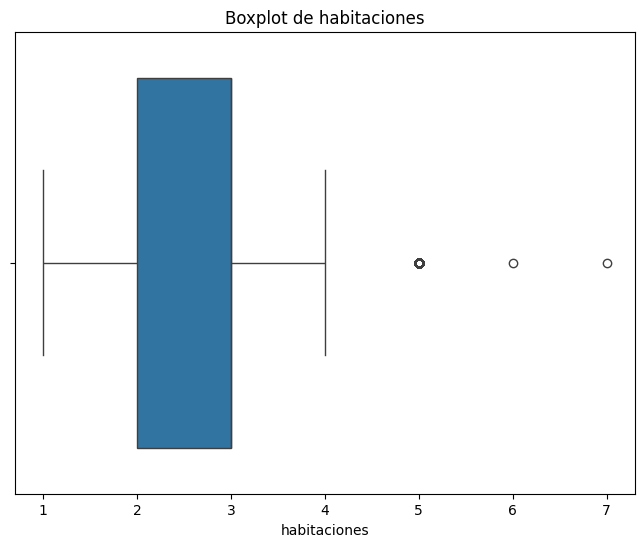

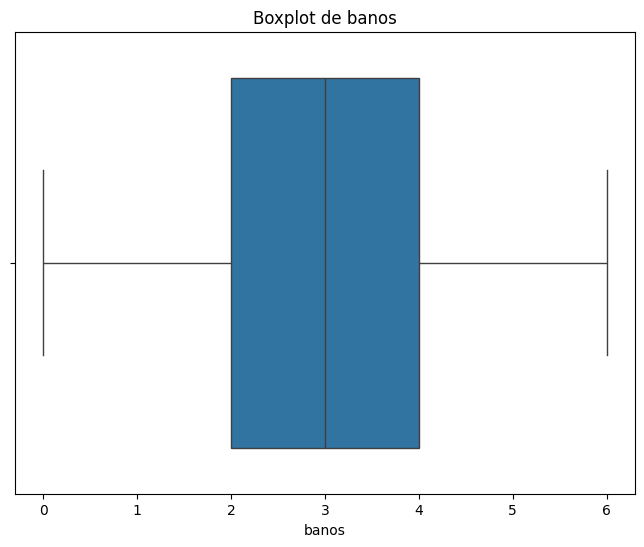

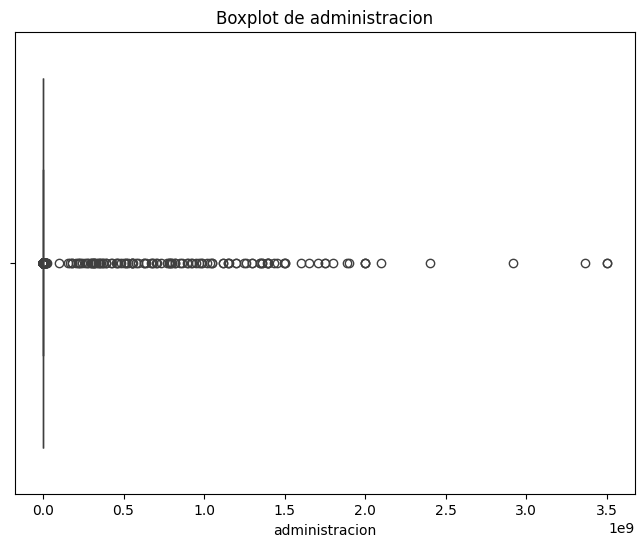

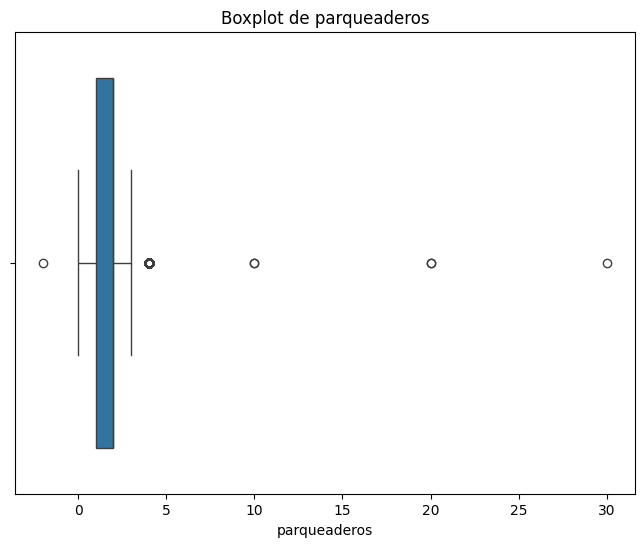

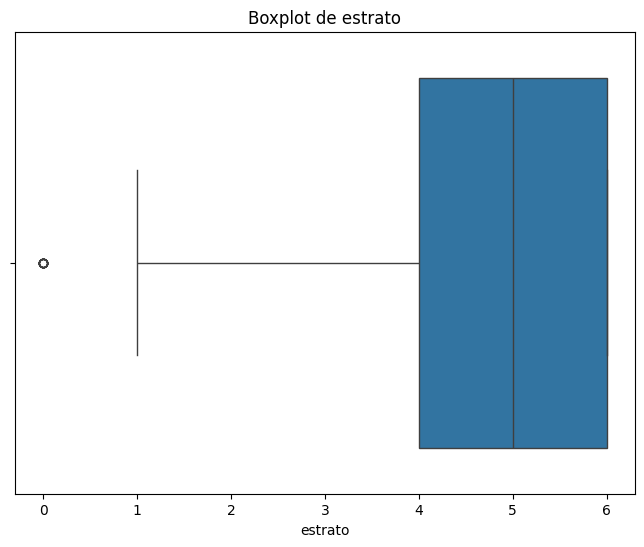

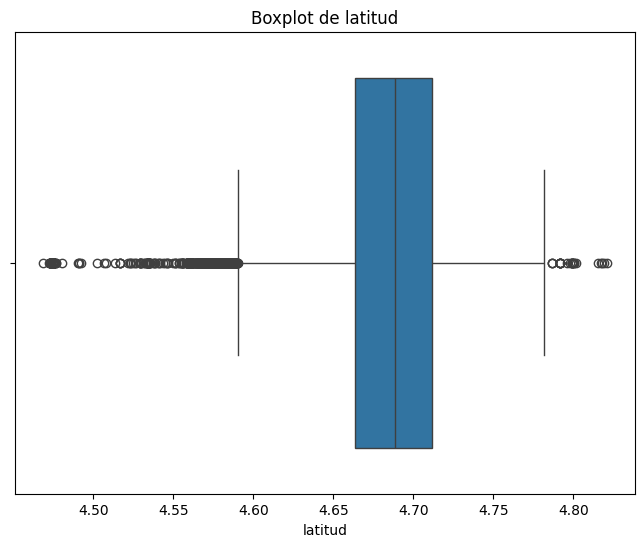

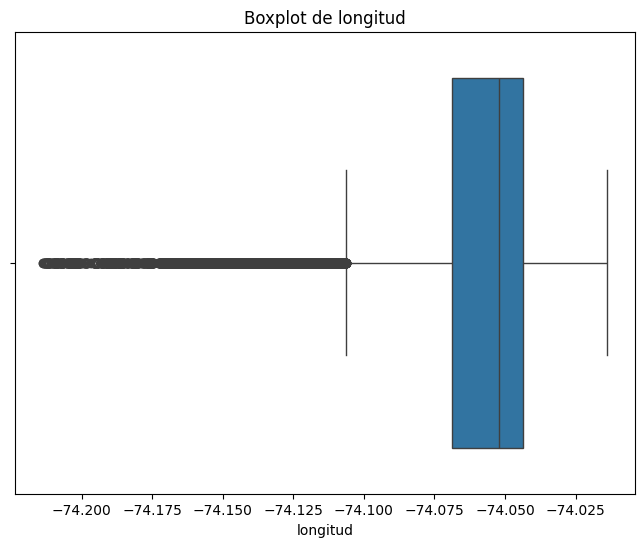

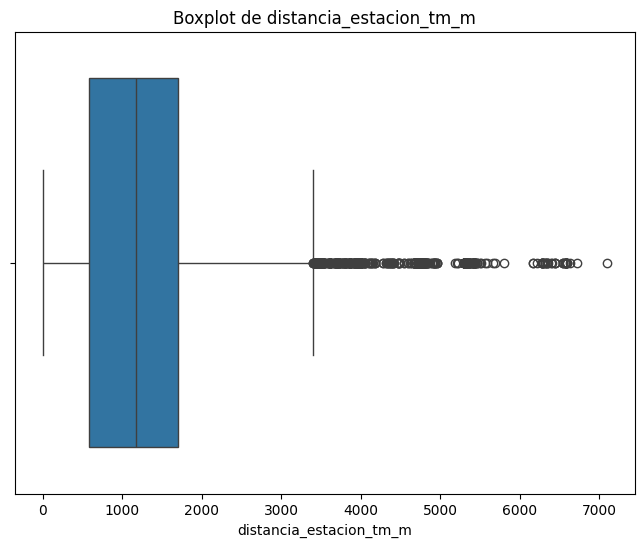

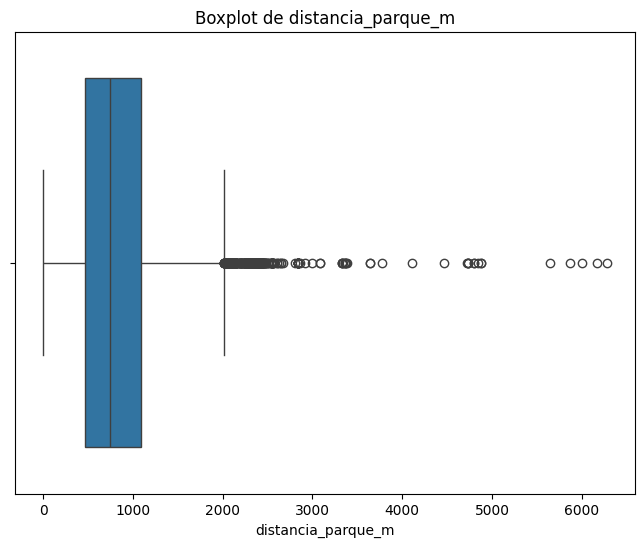

In [ ]:
#Se hace un boxplot para verificar la distribucion de los datos buscando los outliers dependiendo el contexto

cols = ['precio_venta', 'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos', 'estrato', 'latitud', 'longitud',
  'distancia_estacion_tm_m', 'distancia_parque_m']
for column in cols:
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=df[column])
  plt.title(f'Boxplot de {column}')
  plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43013 entries, 4133491 to MC4721977
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tipo_propiedad           43013 non-null  object 
 1   tipo_operacion           43013 non-null  object 
 2   precio_venta             27584 non-null  float64
 3   area                     43013 non-null  float64
 4   habitaciones             43012 non-null  float64
 5   banos                    43012 non-null  float64
 6   administracion           35088 non-null  float64
 7   parqueaderos             43012 non-null  float64
 8   sector                   41372 non-null  object 
 9   estrato                  43012 non-null  float64
 10  antiguedad               43003 non-null  object 
 11  latitud                  43013 non-null  float64
 12  longitud                 43013 non-null  float64
 13  jacuzzi                  43011 non-null  float64
 14  chimenea         

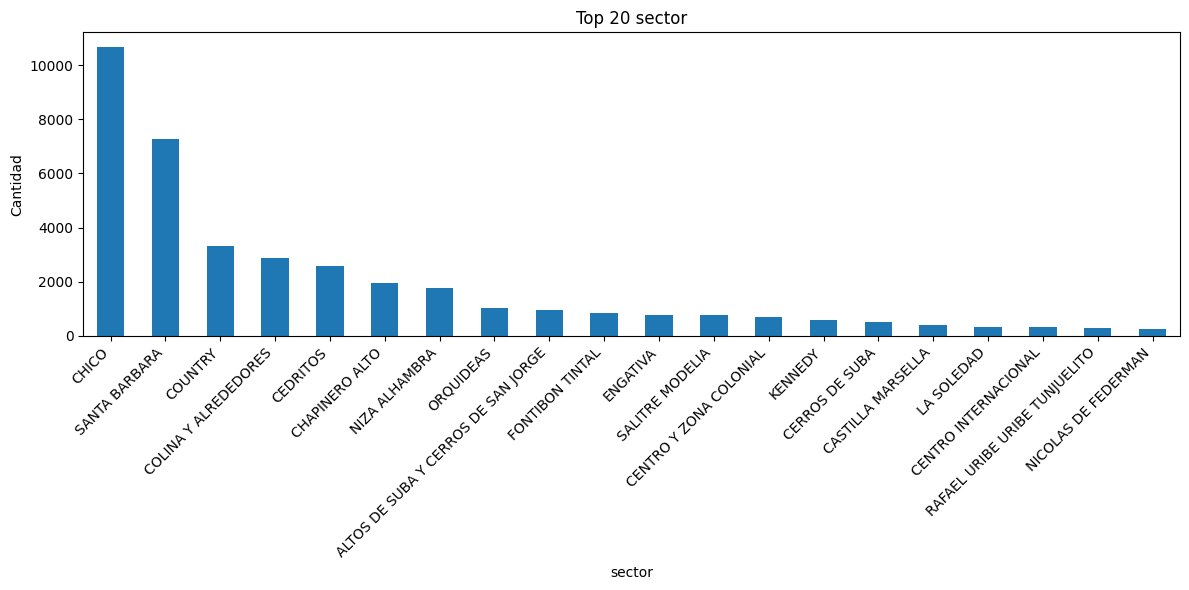

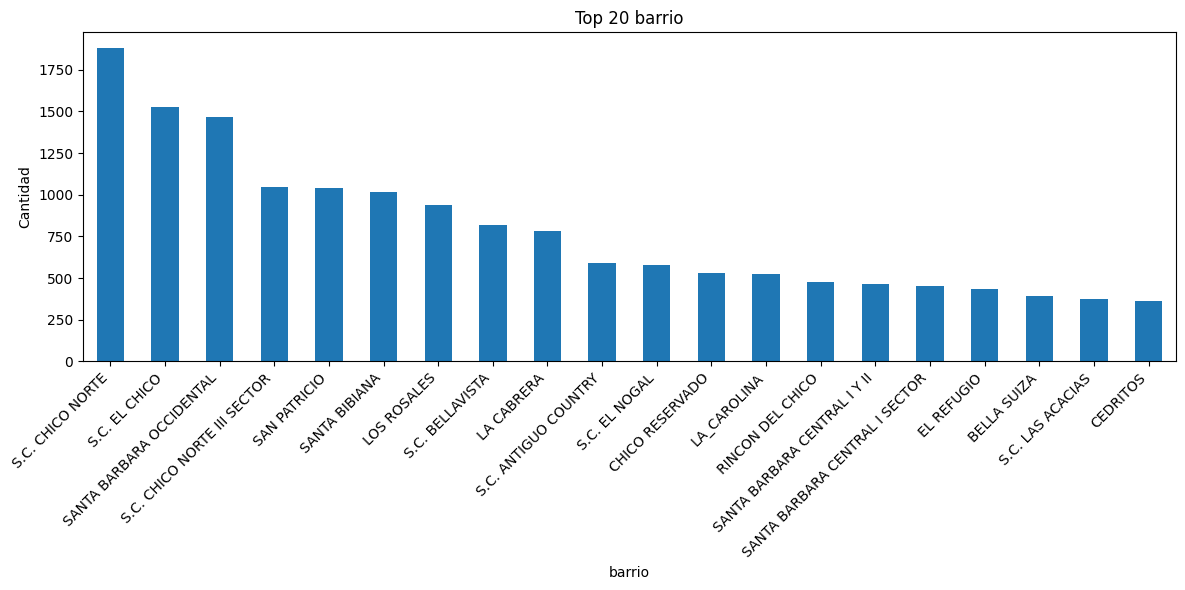

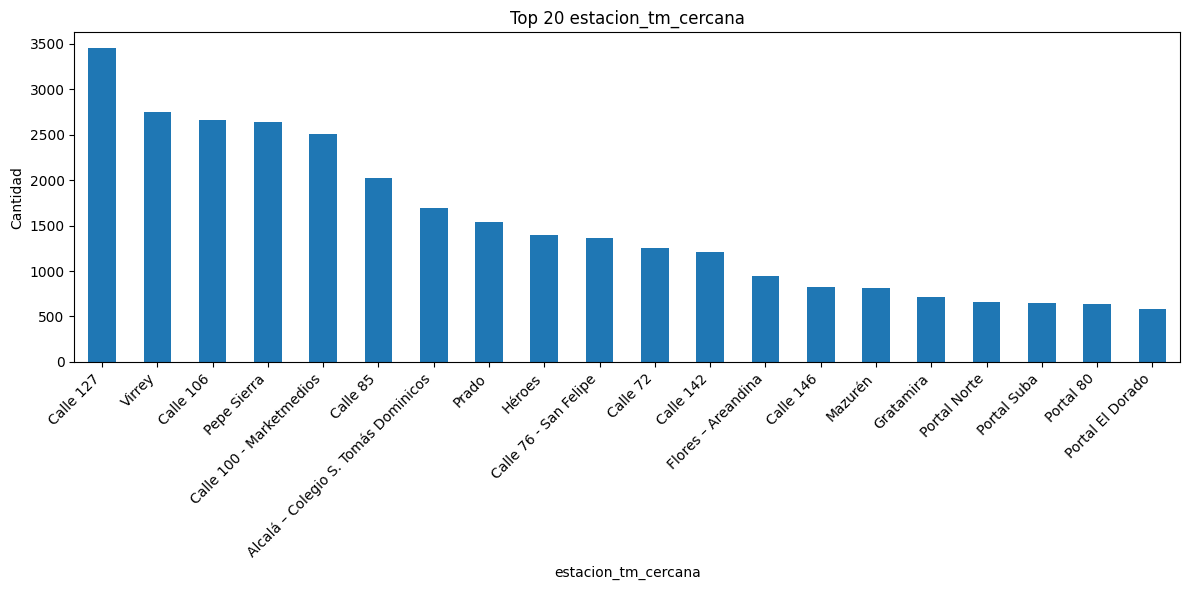

In [ ]:
cols = ['sector', 'barrio', 'estacion_tm_cercana']
for i in cols:
  property_type_counts = df[i].value_counts()
  top_20_property_types = property_type_counts.head(20)
  plt.figure(figsize=(12, 6))
  top_20_property_types.plot(kind='bar')
  plt.title(f'Top 20 {i}')
  plt.xlabel(i)
  plt.ylabel('Cantidad')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

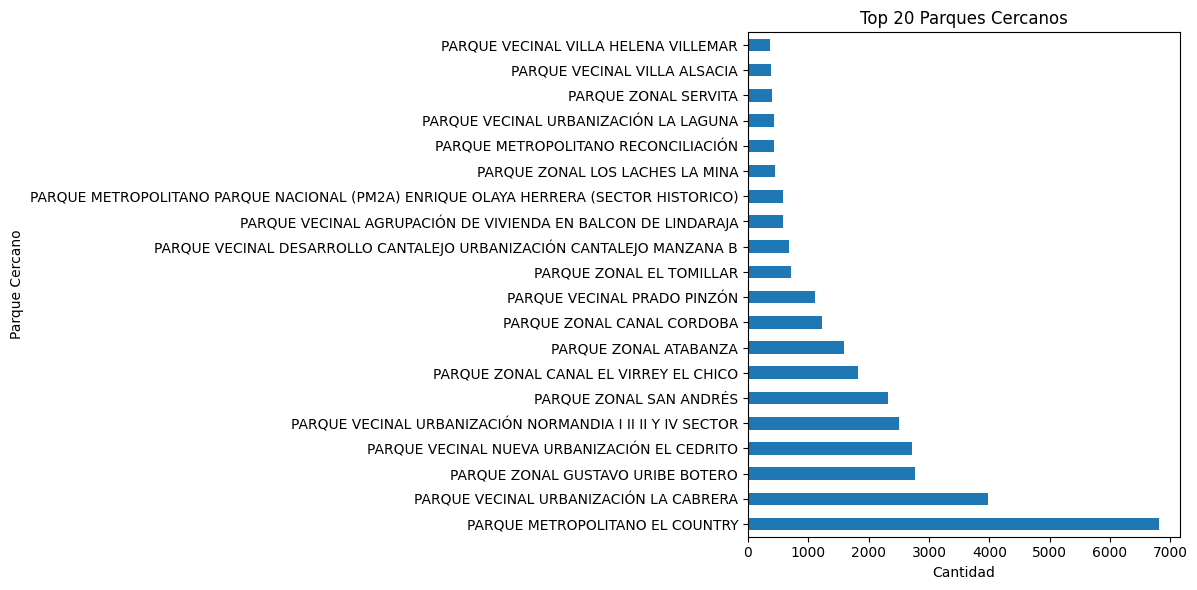

In [ ]:
parque_cercano_counts = df['parque_cercano'].value_counts()
top_20_parques = parque_cercano_counts.head(20)
plt.figure(figsize=(12, 6))
top_20_parques.plot(kind='barh')
plt.title('Top 20 Parques Cercanos')
plt.xlabel('Cantidad')
plt.ylabel('Parque Cercano')
plt.tight_layout()
plt.show()

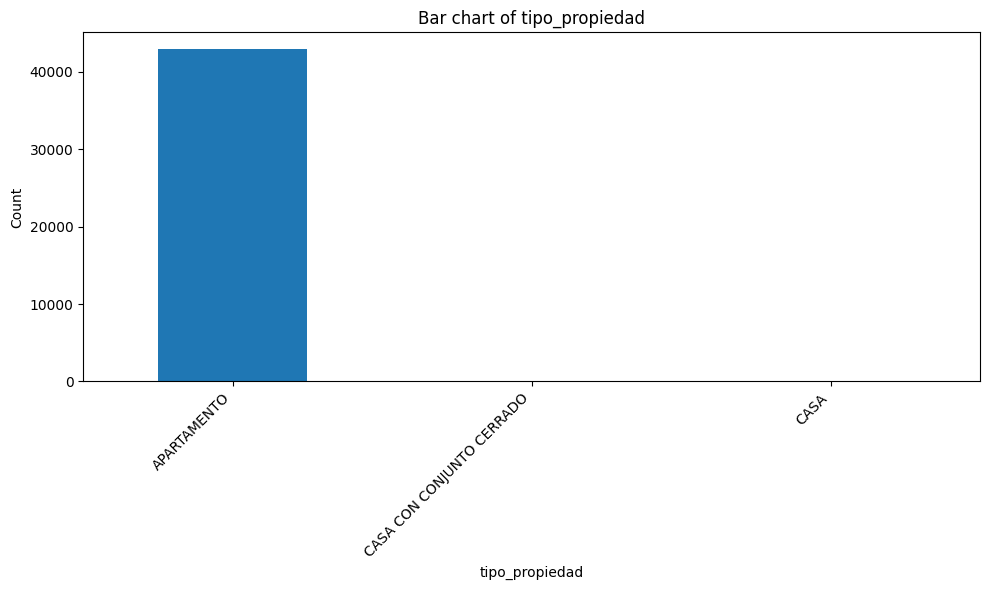

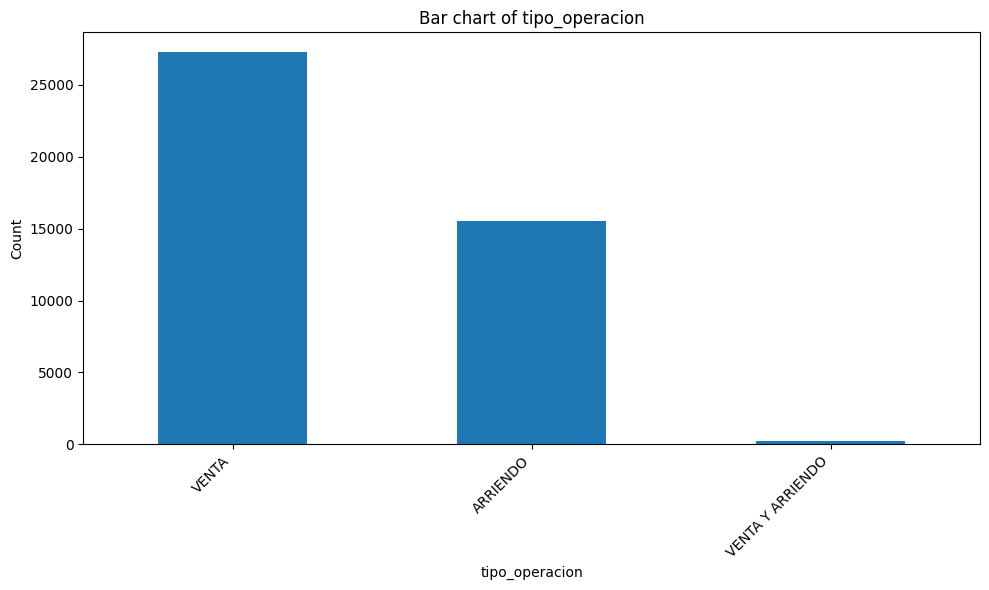

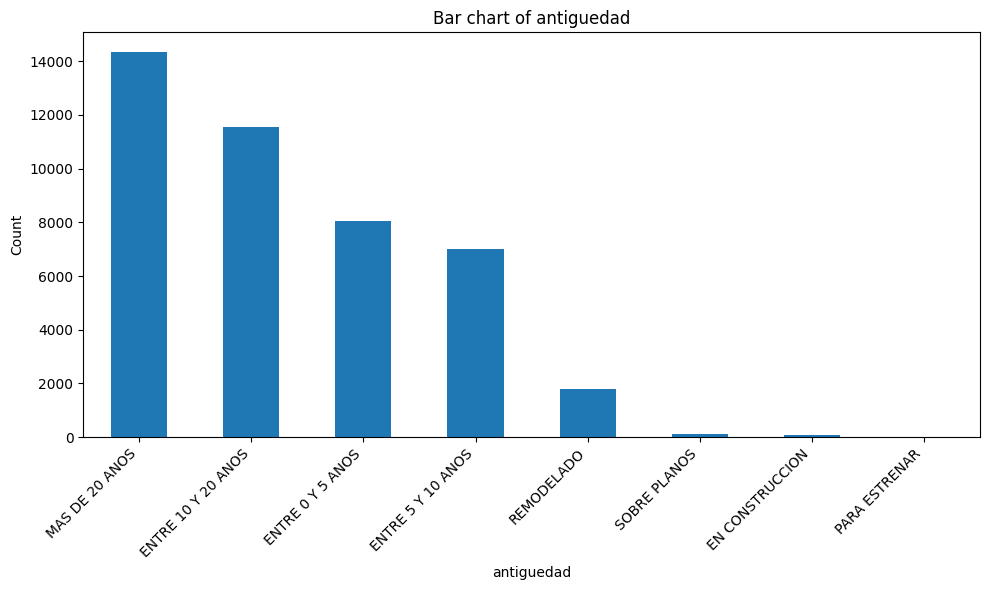

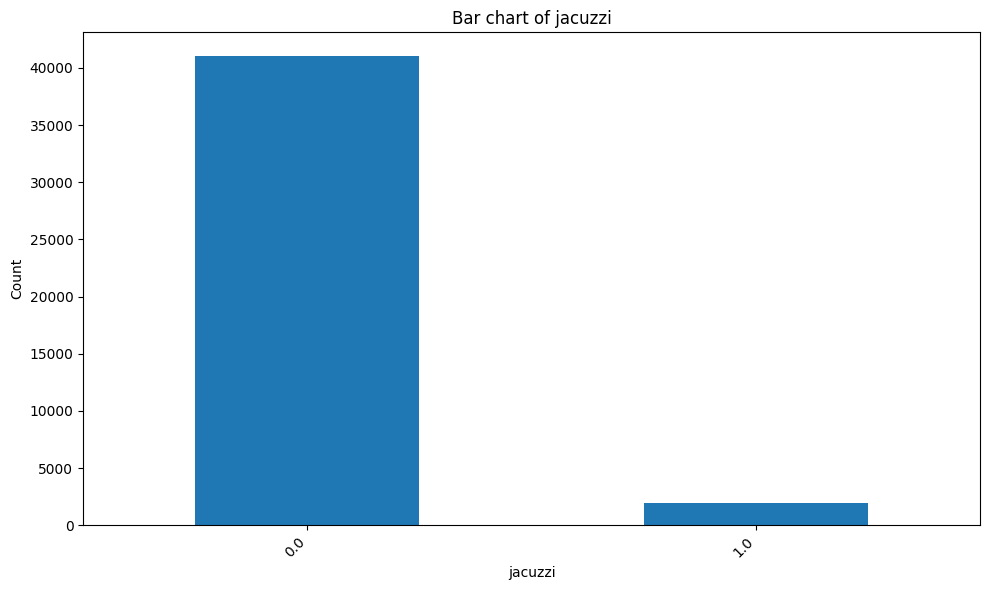

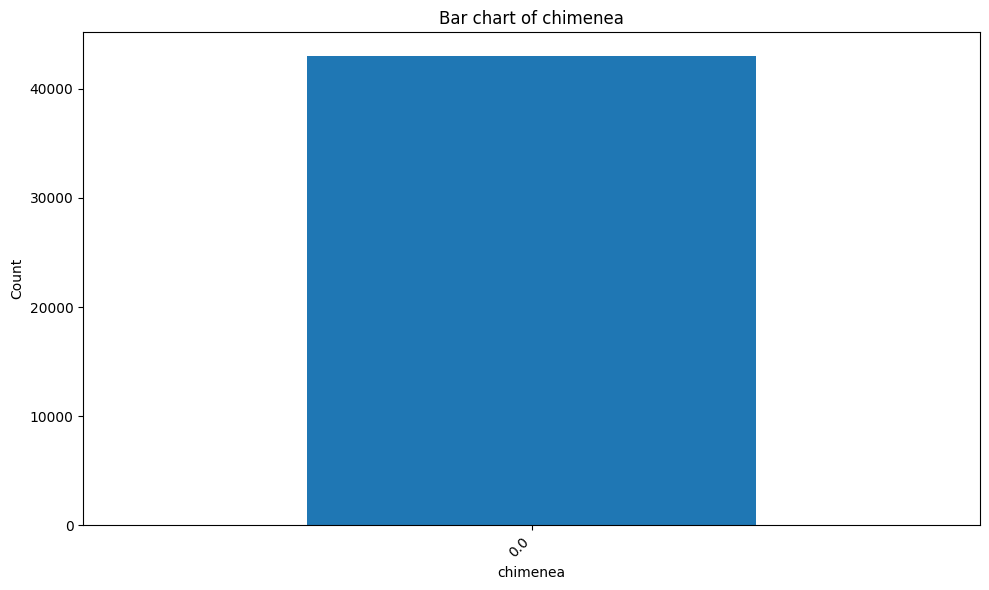

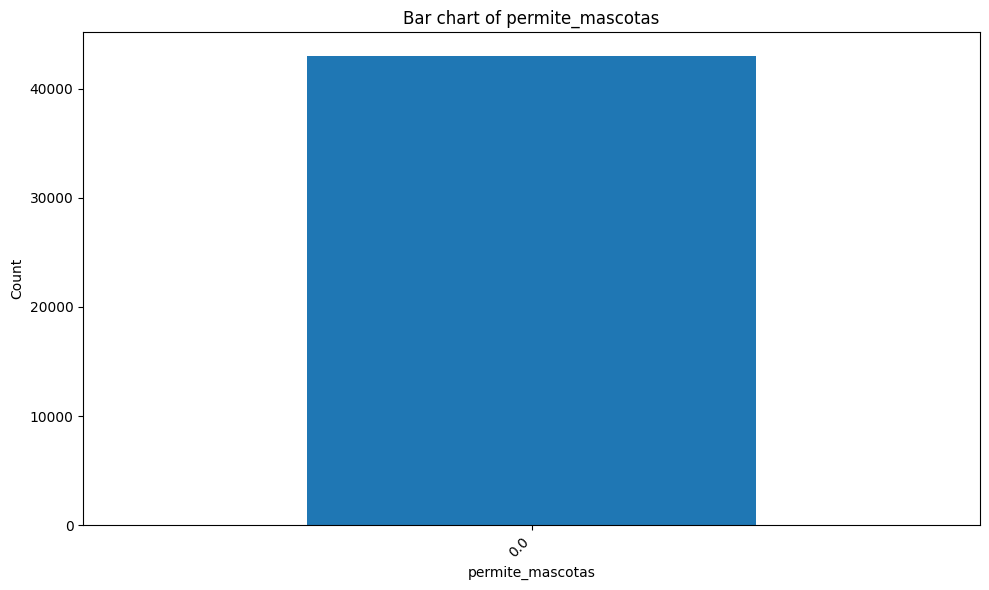

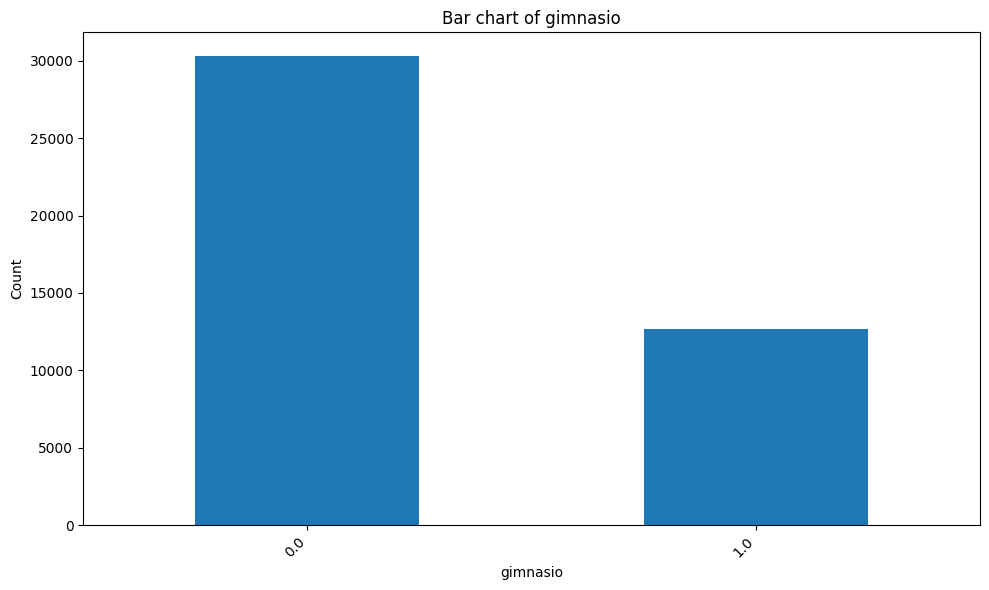

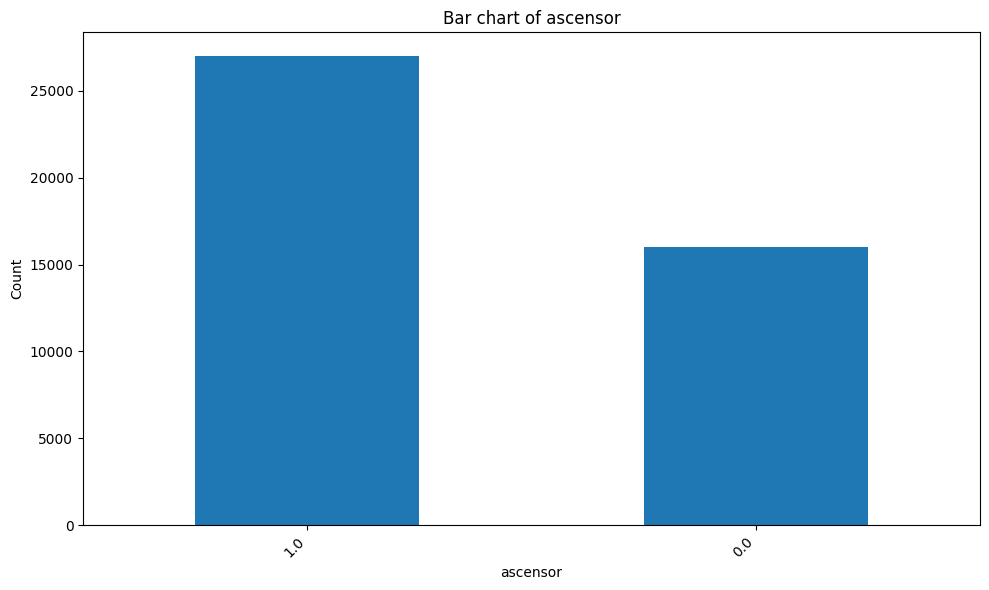

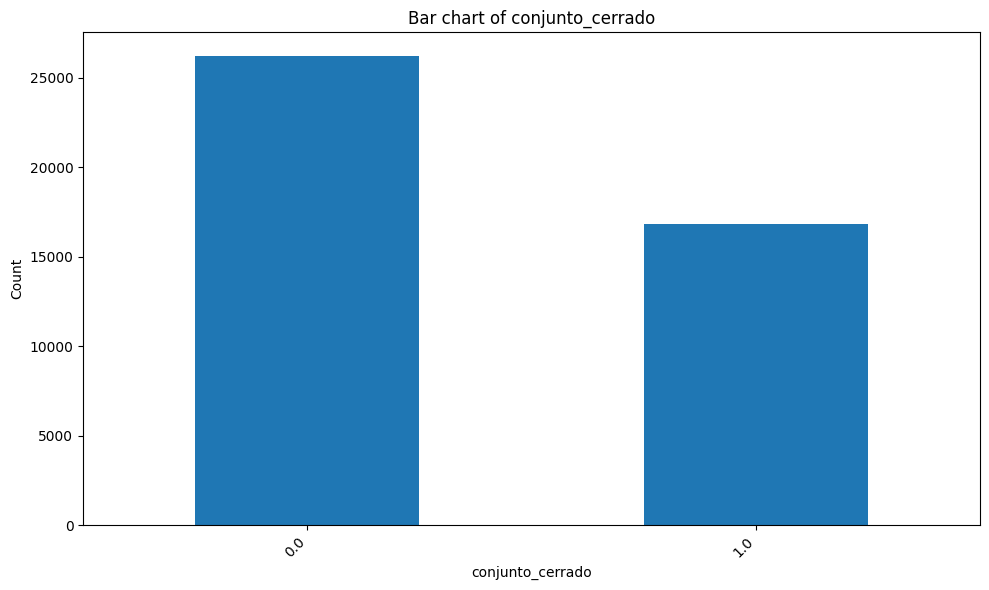

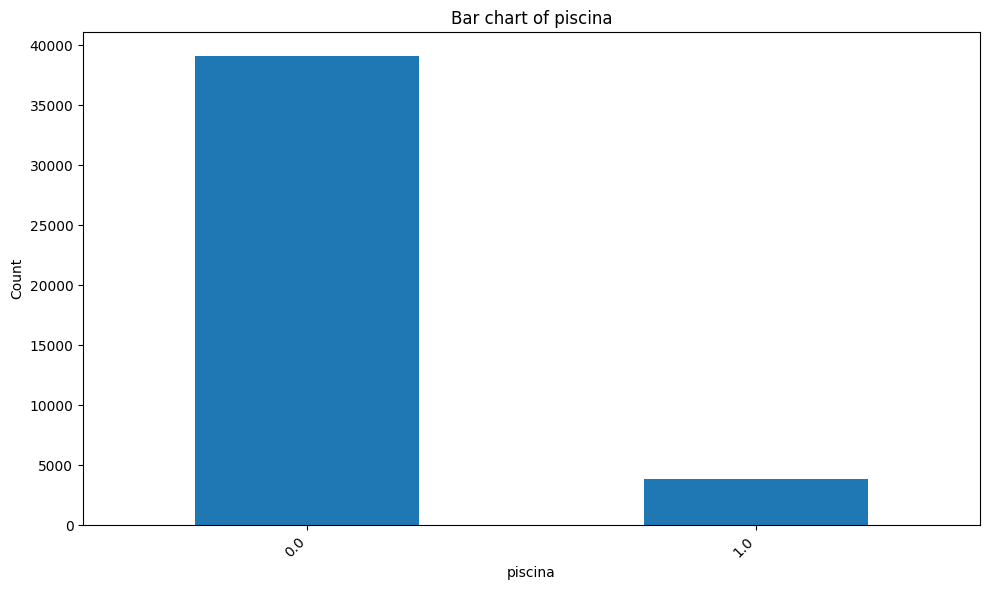

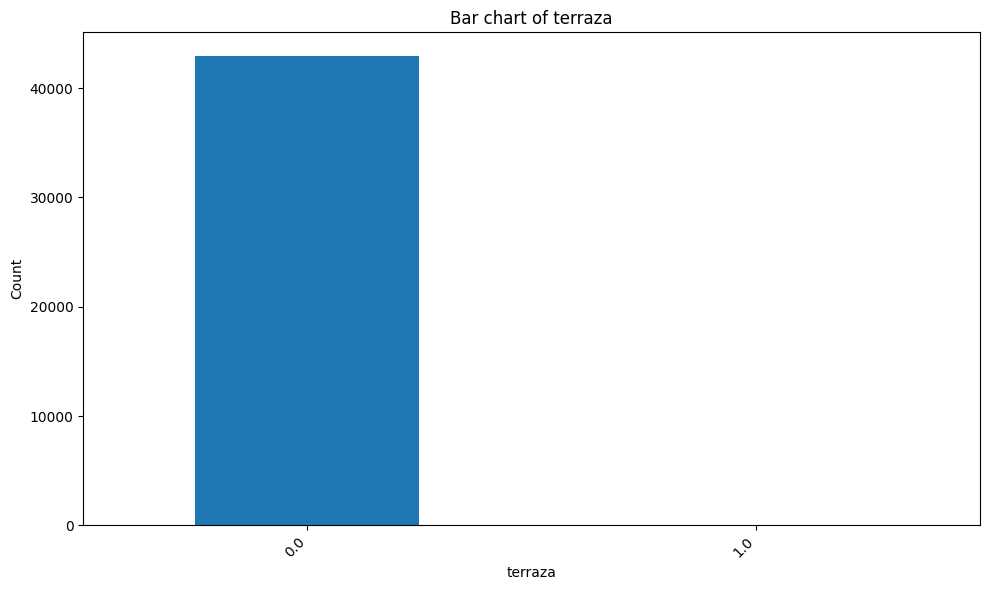

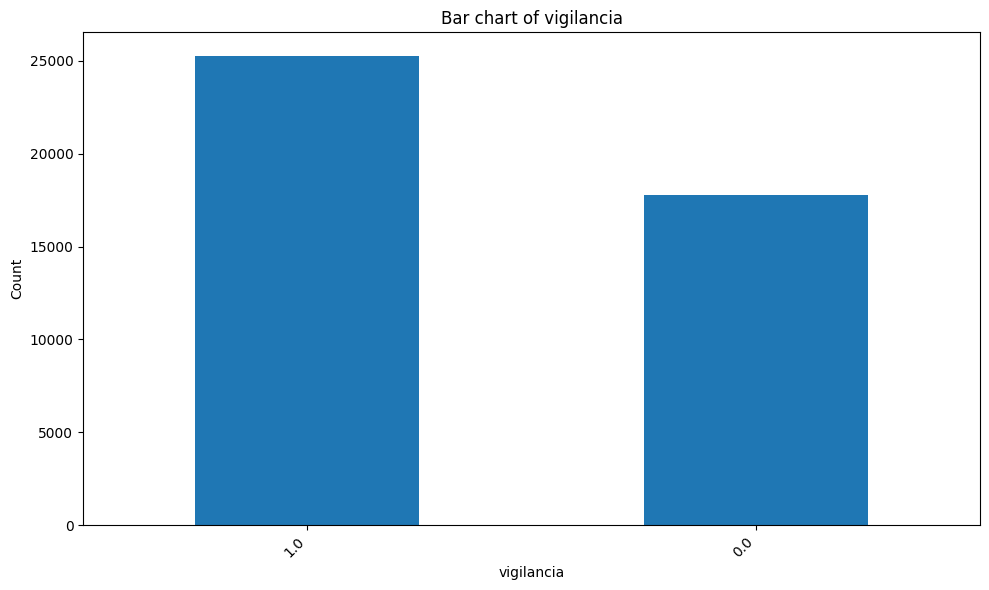

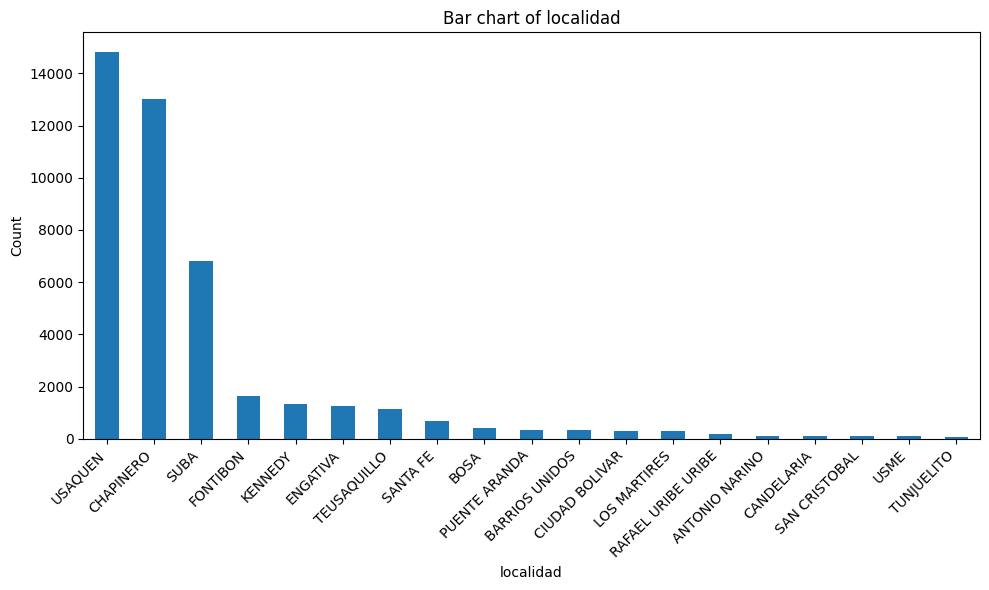

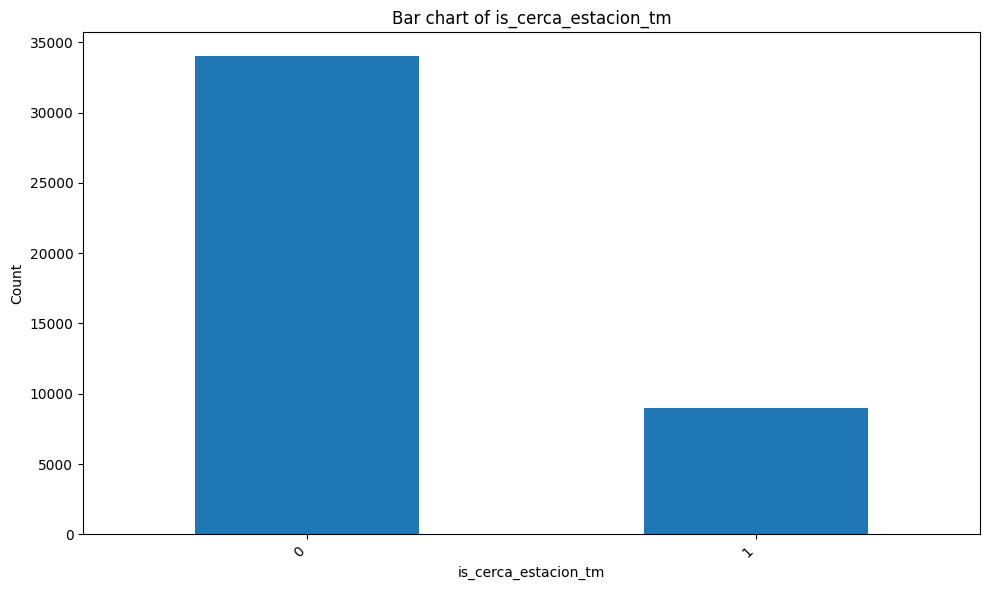

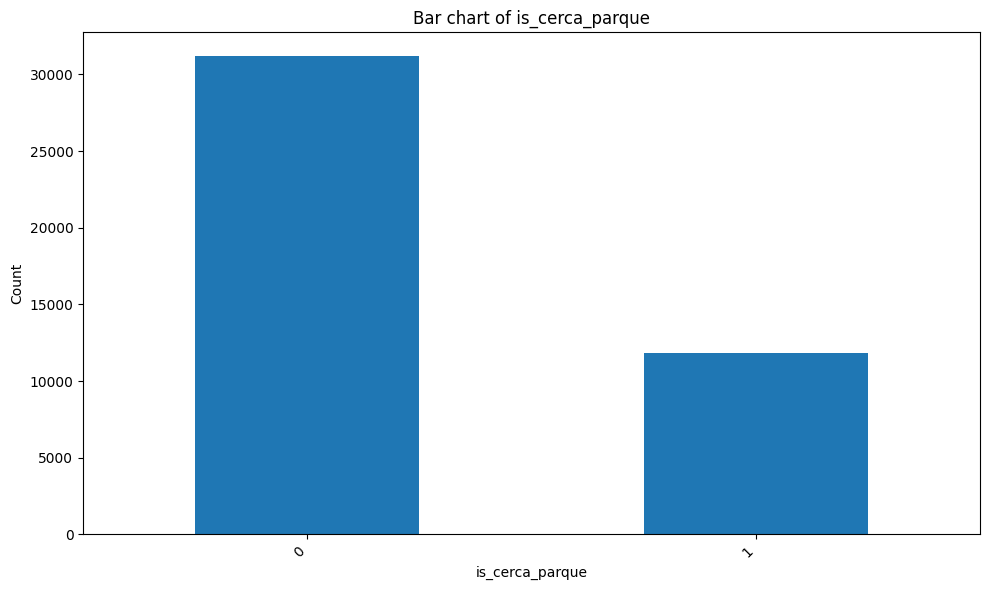

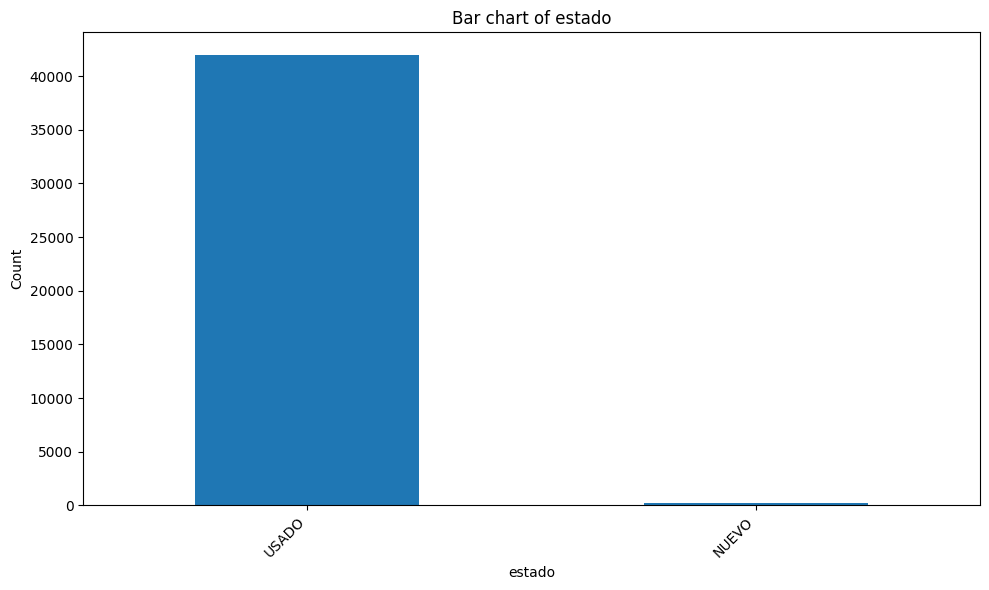

In [ ]:
#Se procede a realizar la grafica de barras para aquellas columnas que sean categoricas

cols = ['tipo_propiedad', 'tipo_operacion', 'antiguedad', 'jacuzzi', 'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
    'conjunto_cerrado' , 'piscina', 'terraza', 'vigilancia', 'localidad', 'is_cerca_estacion_tm', 'is_cerca_parque', 'estado']

for col in cols:
  plt.figure(figsize=(10, 6))
  df[col].value_counts().plot(kind='bar')
  plt.title(f'Bar chart of {col}')
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

In [ ]:
#Las variables de permiten_mascota y chimenea al tener solo una categoria no representan ninguna importancia
df.drop('permite_mascotas', axis=1, inplace=True)
df.drop('chimenea', axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43013 entries, 4133491 to MC4721977
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tipo_propiedad           43013 non-null  object 
 1   tipo_operacion           43013 non-null  object 
 2   precio_venta             27584 non-null  float64
 3   area                     43013 non-null  float64
 4   habitaciones             43012 non-null  float64
 5   banos                    43012 non-null  float64
 6   administracion           35088 non-null  float64
 7   parqueaderos             43012 non-null  float64
 8   sector                   41372 non-null  object 
 9   estrato                  43012 non-null  float64
 10  antiguedad               43003 non-null  object 
 11  latitud                  43013 non-null  float64
 12  longitud                 43013 non-null  float64
 13  jacuzzi                  43011 non-null  float64
 14  gimnasio         

In [ ]:
#Encontramos el edificio mas alto para tener el piso mas alto en bogota: https://es.wikipedia.org/wiki/Anexo:Edificios_m%C3%A1s_altos_de_Bogot%C3%A1
#df = df[df['piso'] <= 67]
#df = df[df['piso'] >= 1]
#df = df[df['banos'] >= 0]

#df = df[df['parqueaderos'] >= 0]

#df = df[df['distancia_estacion_tm_m'] >= 5]

df = df[(df['precio_arriendo'] <= 20000000) | (df['precio_arriendo'].isna())]

df = df[(df['area'] <= 1000) | (df['area'].isna())]

df = df[(df['precio_venta'] < 1000000000) | (df['precio_venta'].isna())]

df = df[(df['administracion'] < 2000000) | (df['administracion'].isna())]

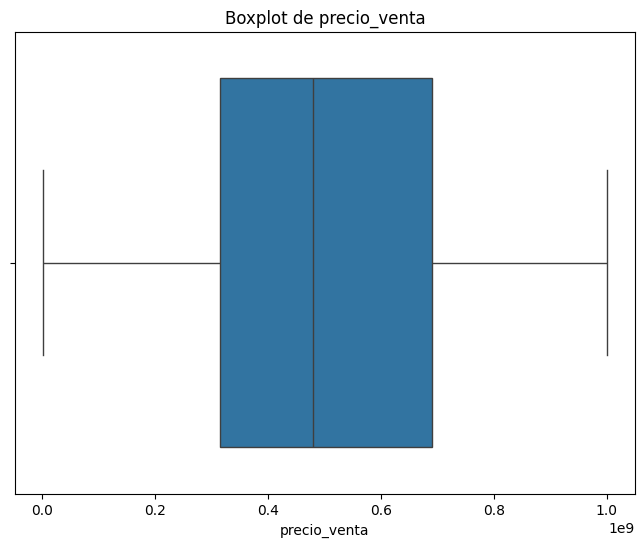

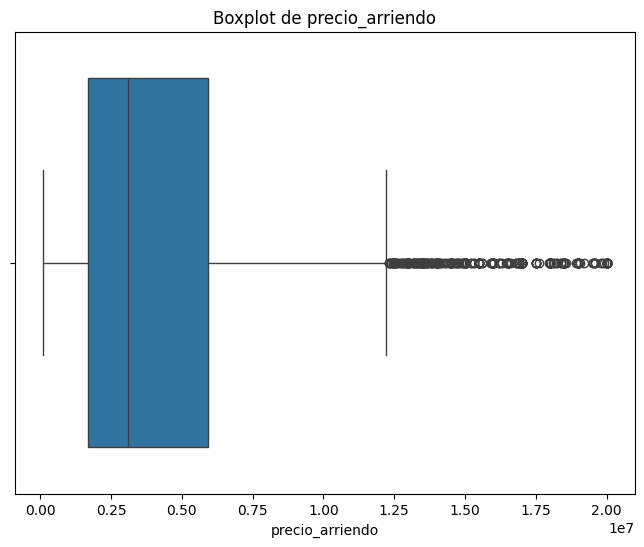

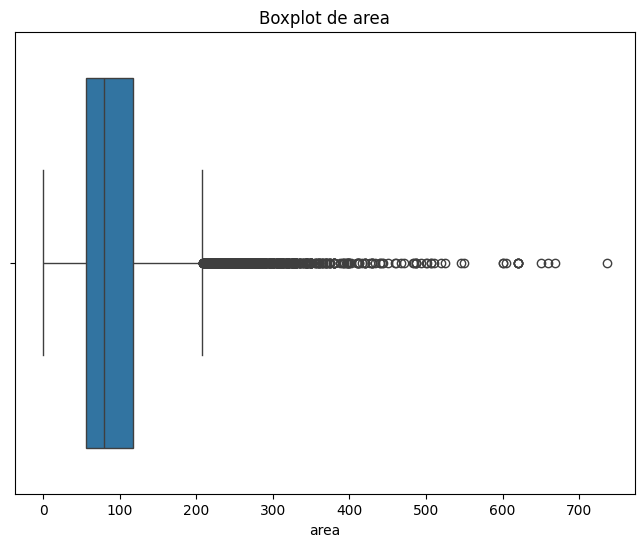

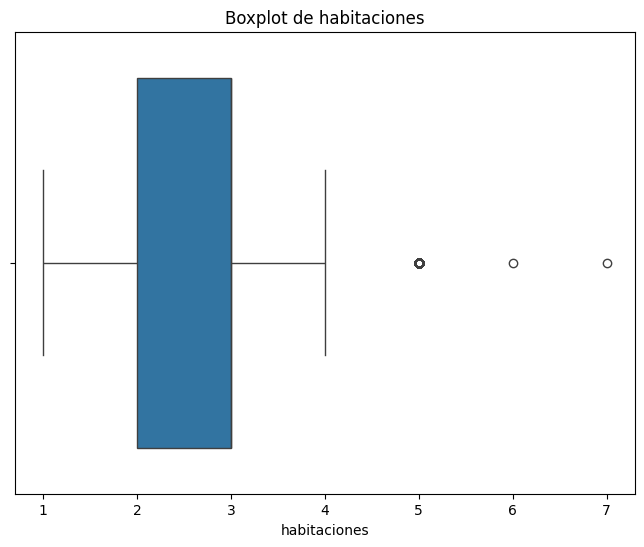

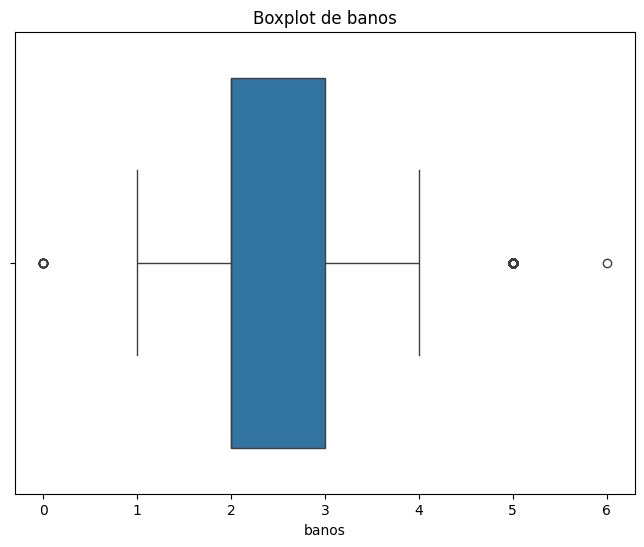

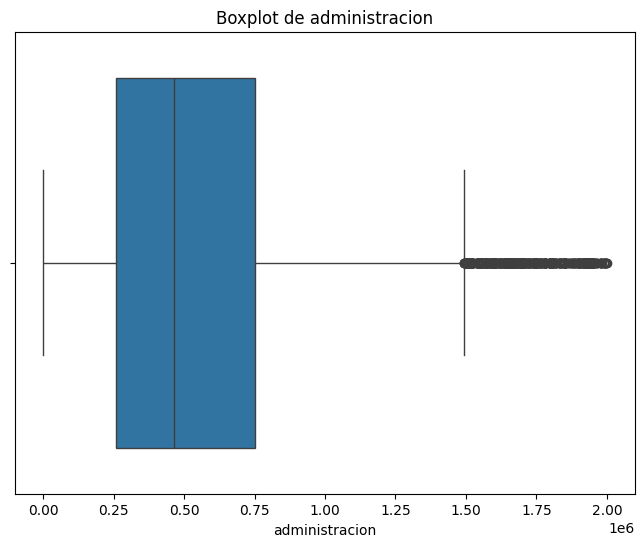

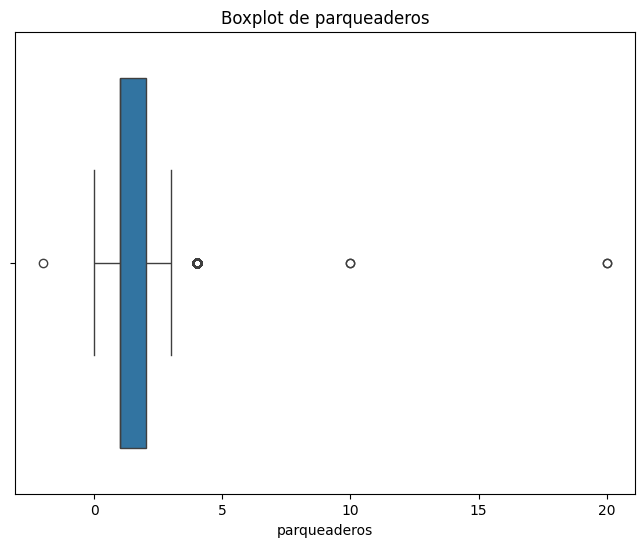

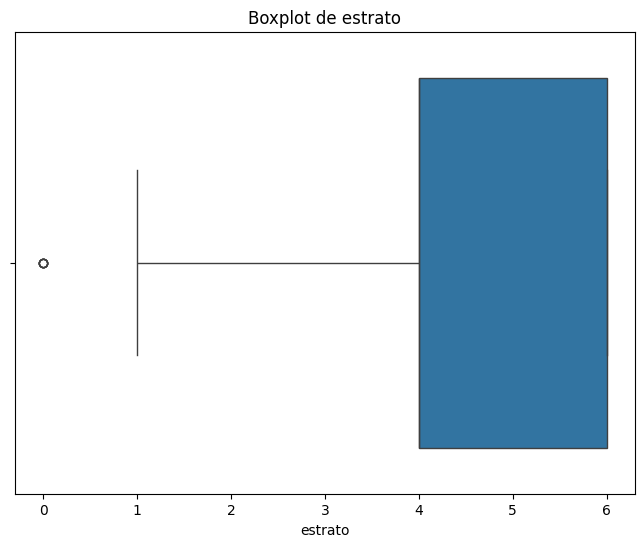

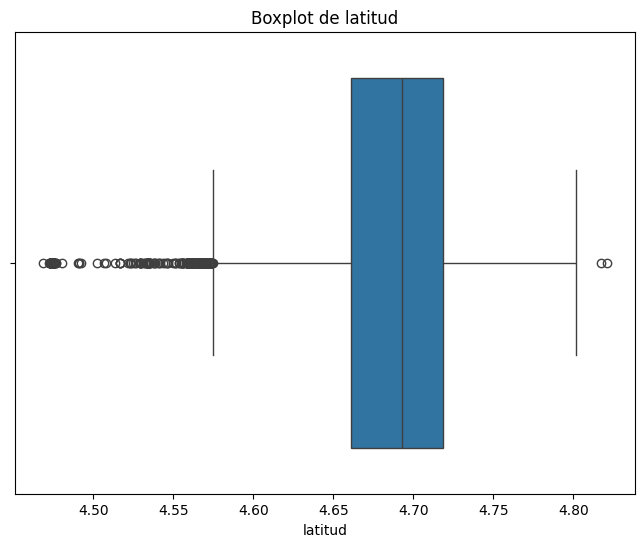

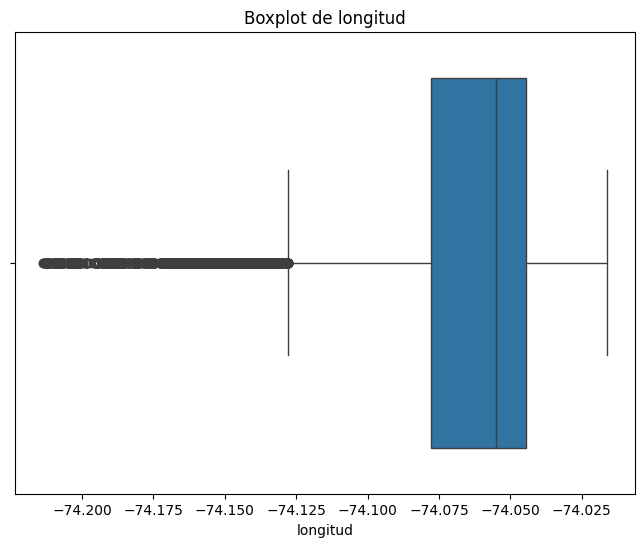

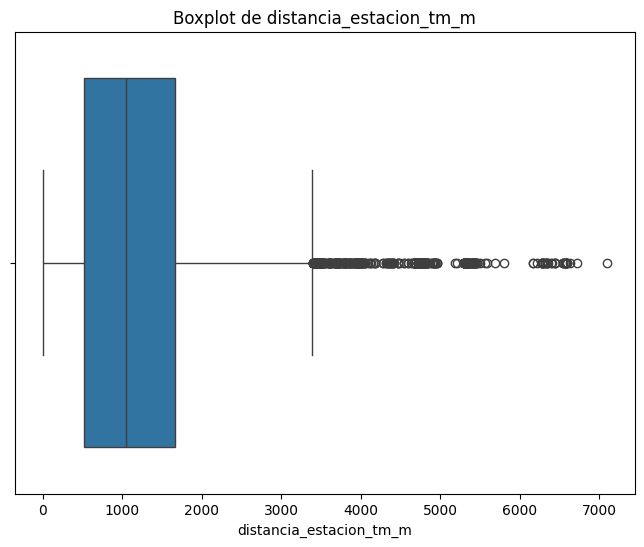

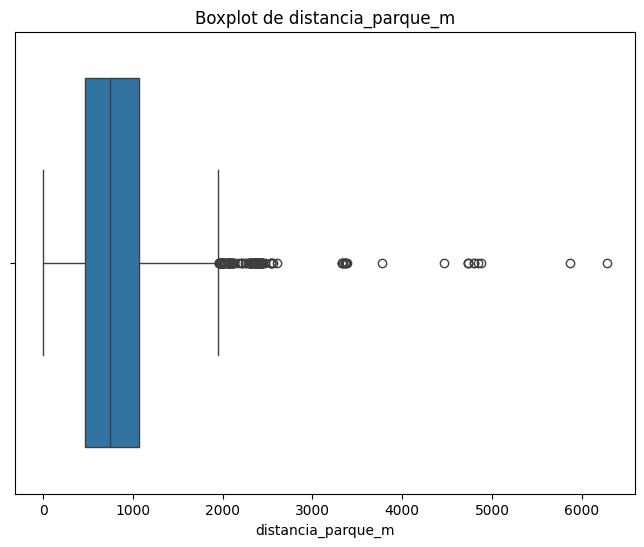

In [ ]:
#Verificamos nuevamente los datos
cols = ['precio_venta', 'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos', 'estrato', 'latitud', 'longitud',
  'distancia_estacion_tm_m', 'distancia_parque_m']
for column in cols:
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=df[column])
  plt.title(f'Boxplot de {column}')
  plt.show()

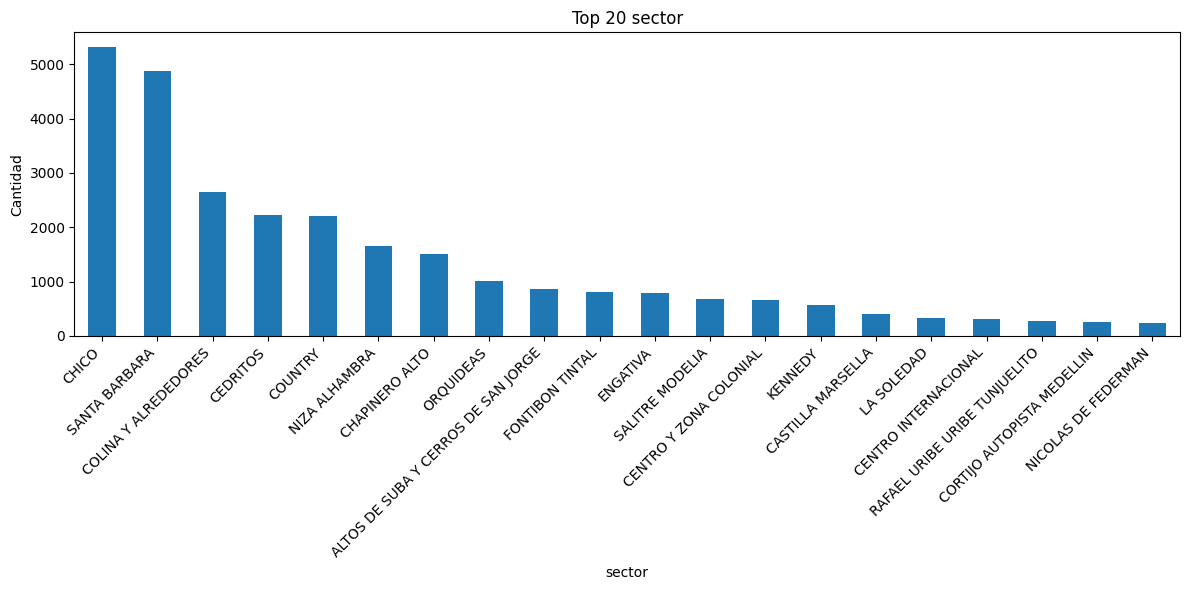

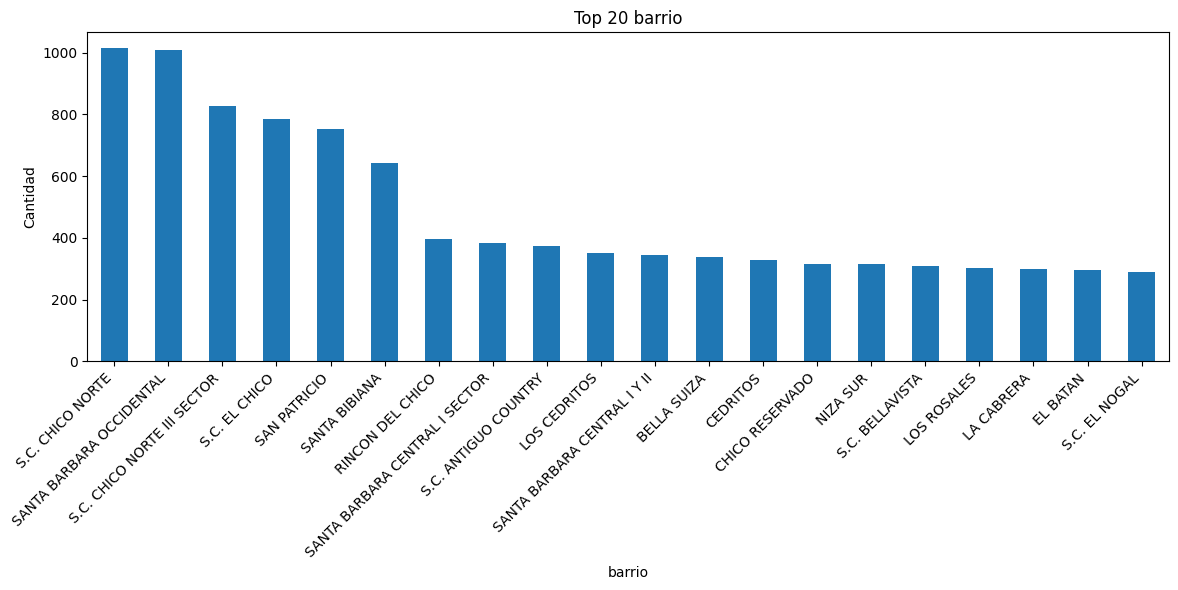

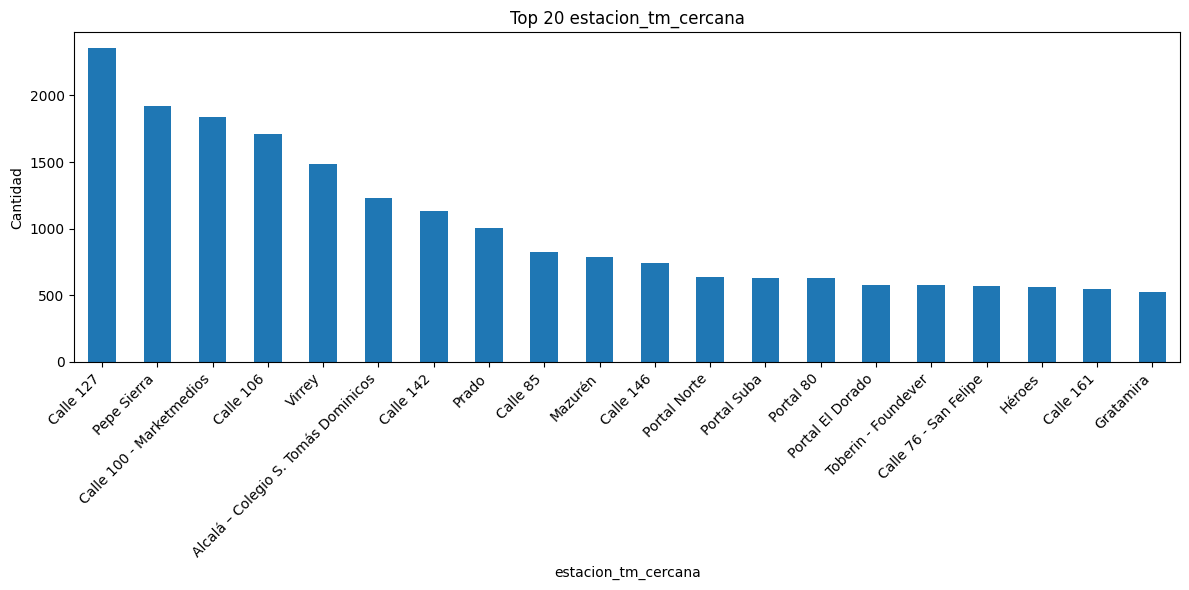

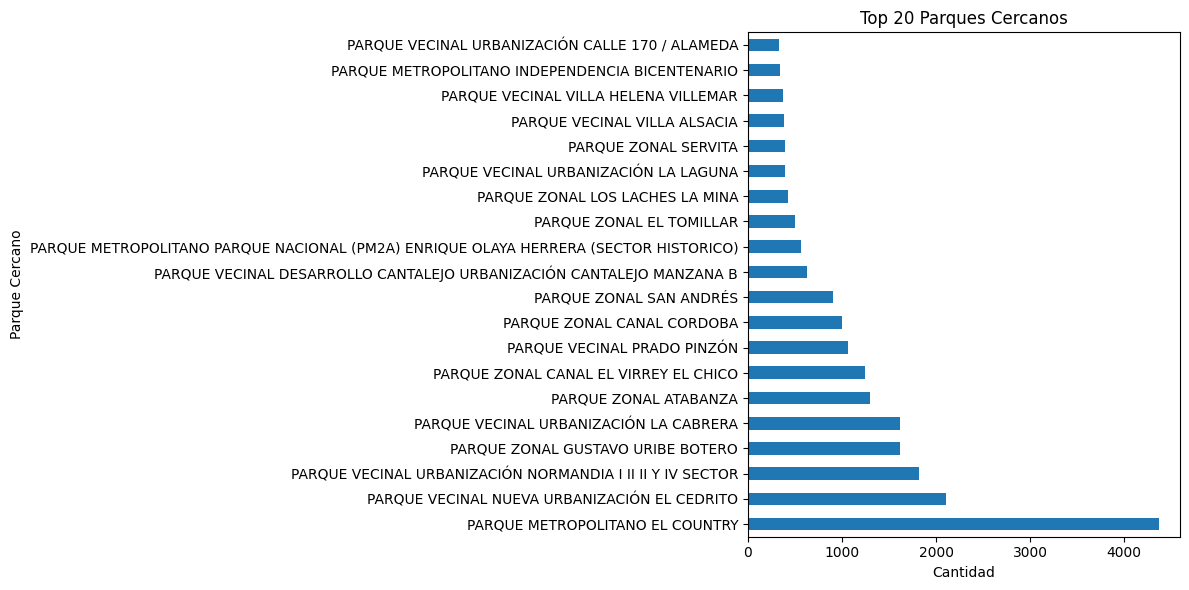

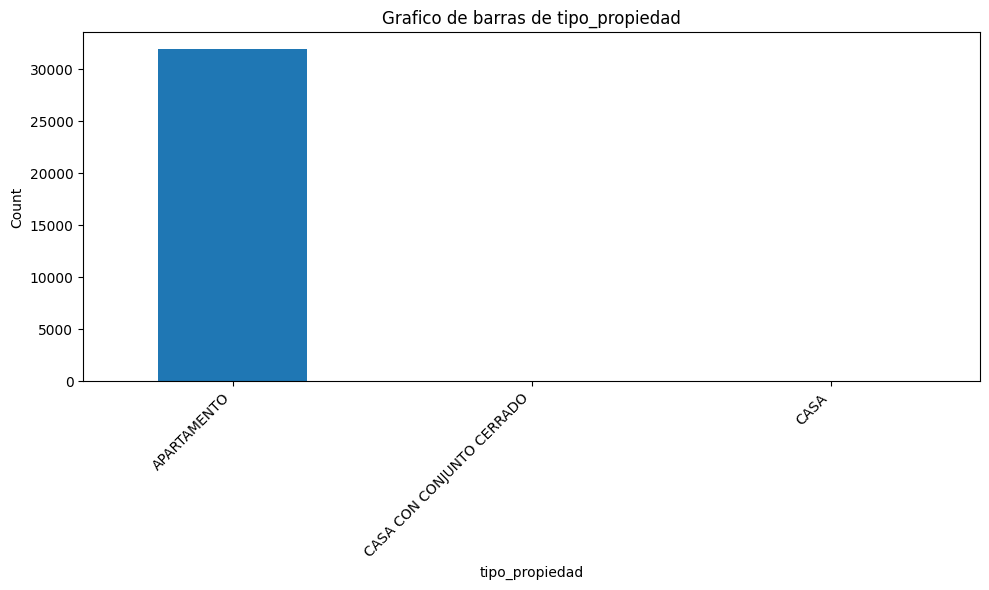

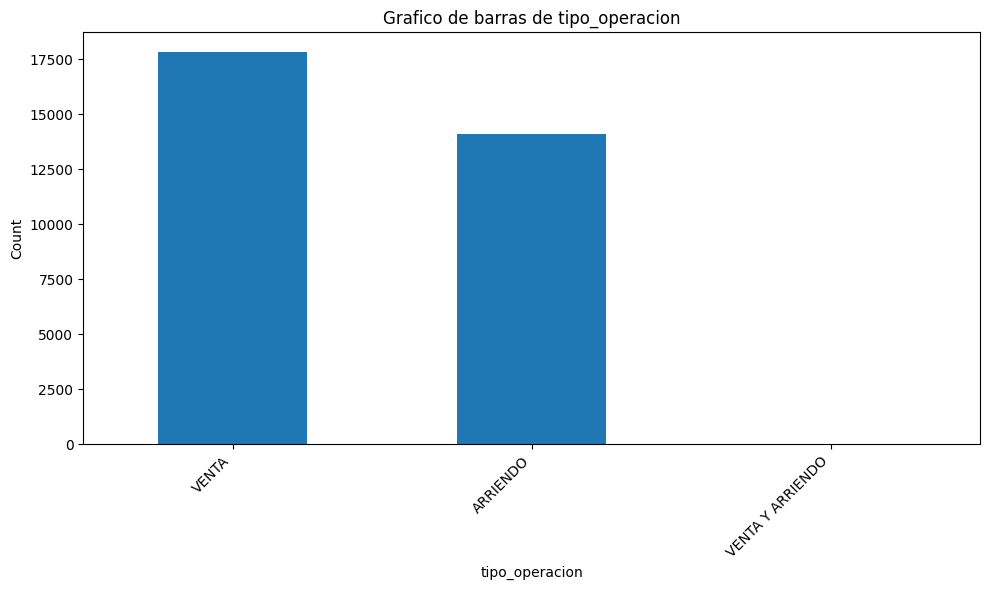

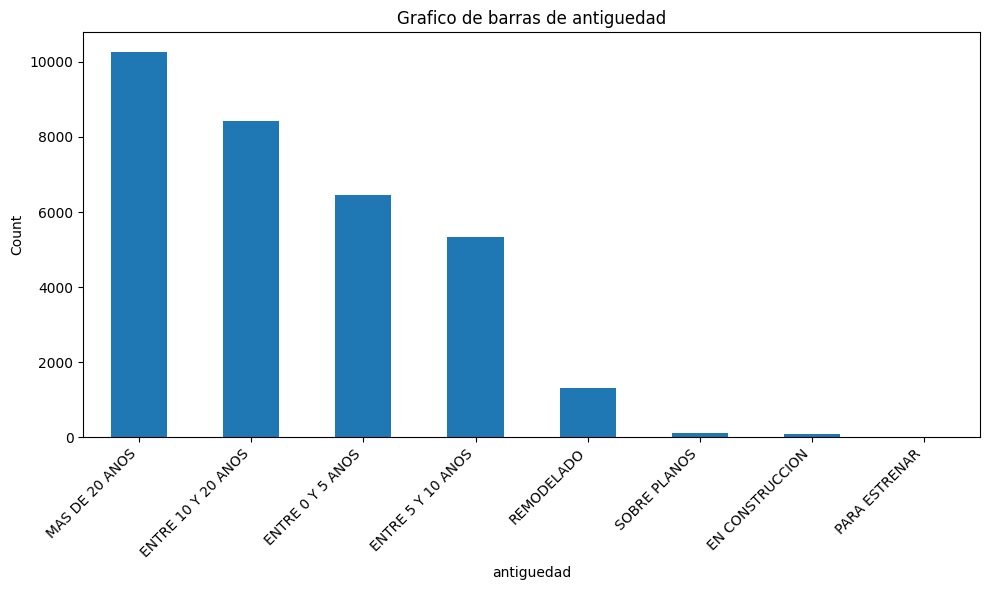

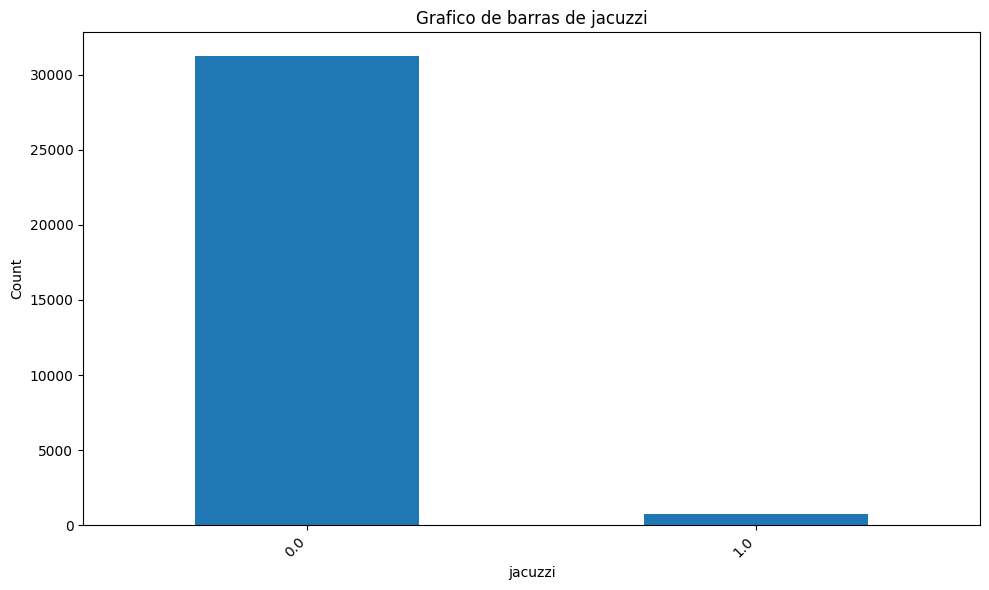

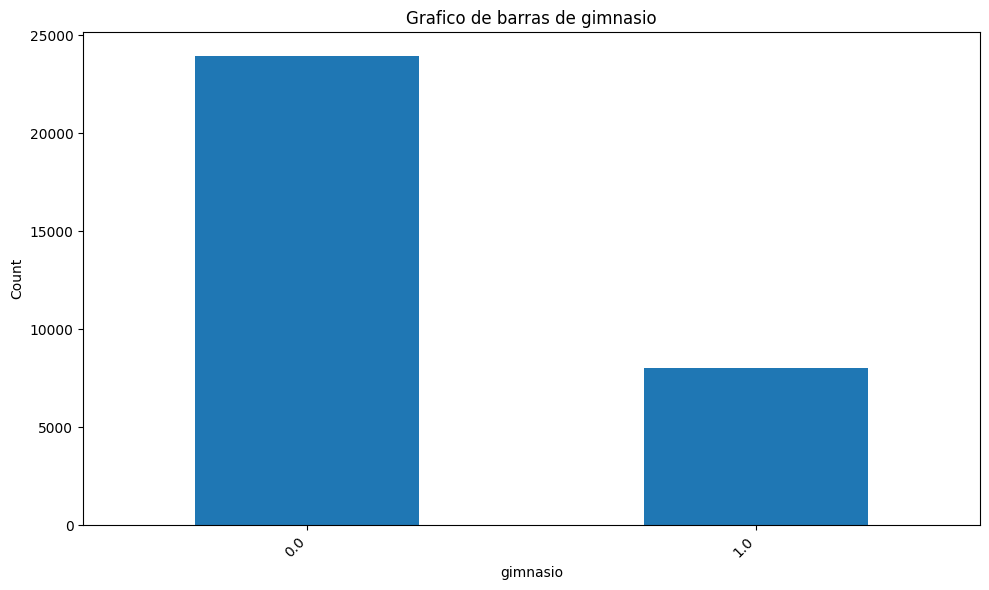

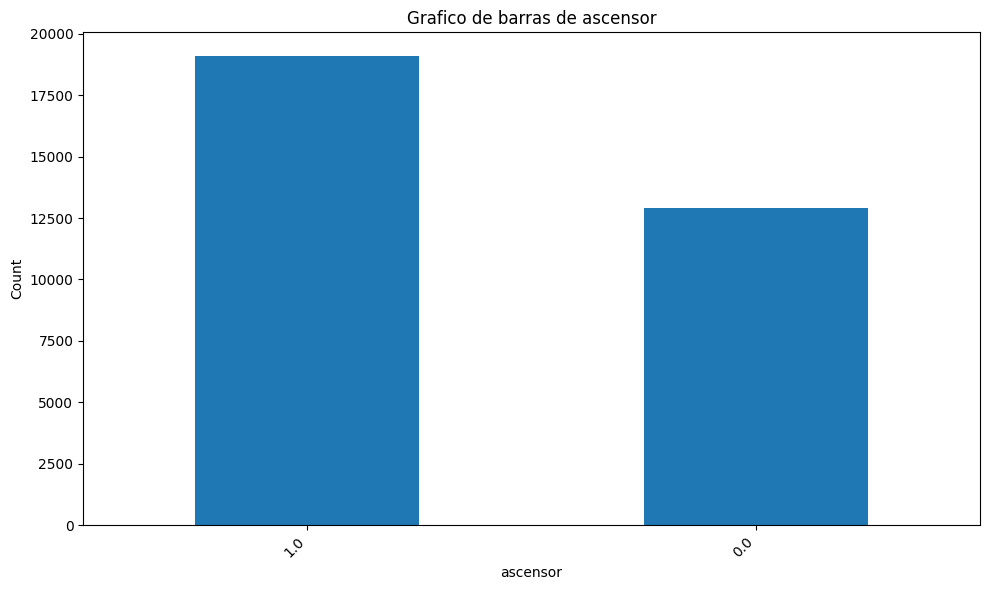

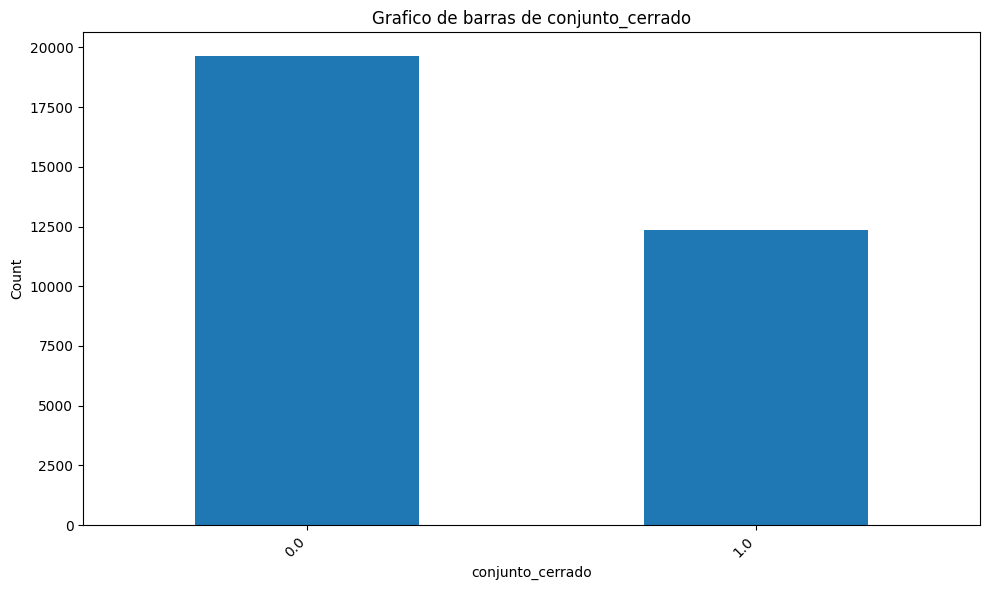

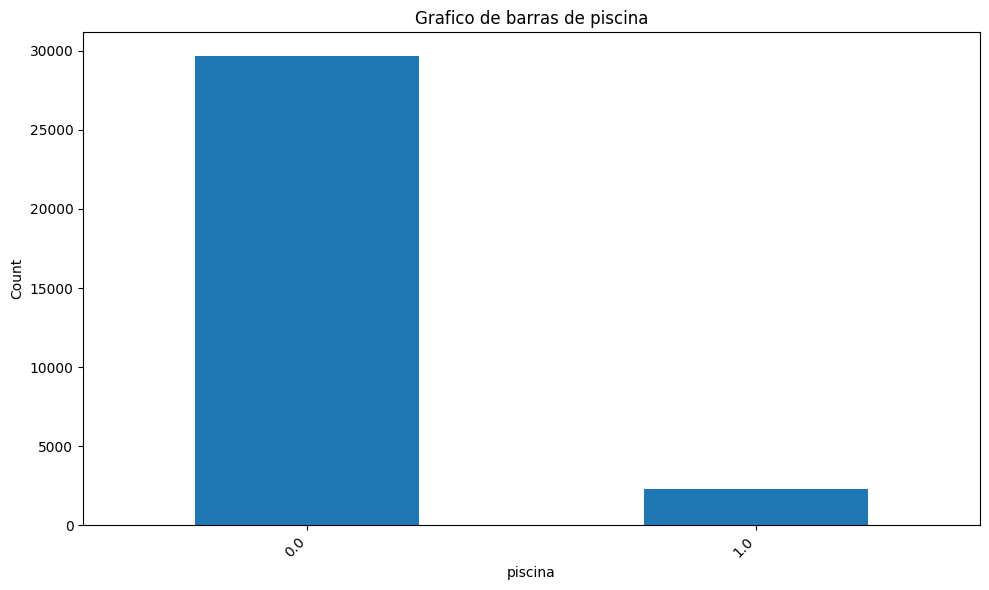

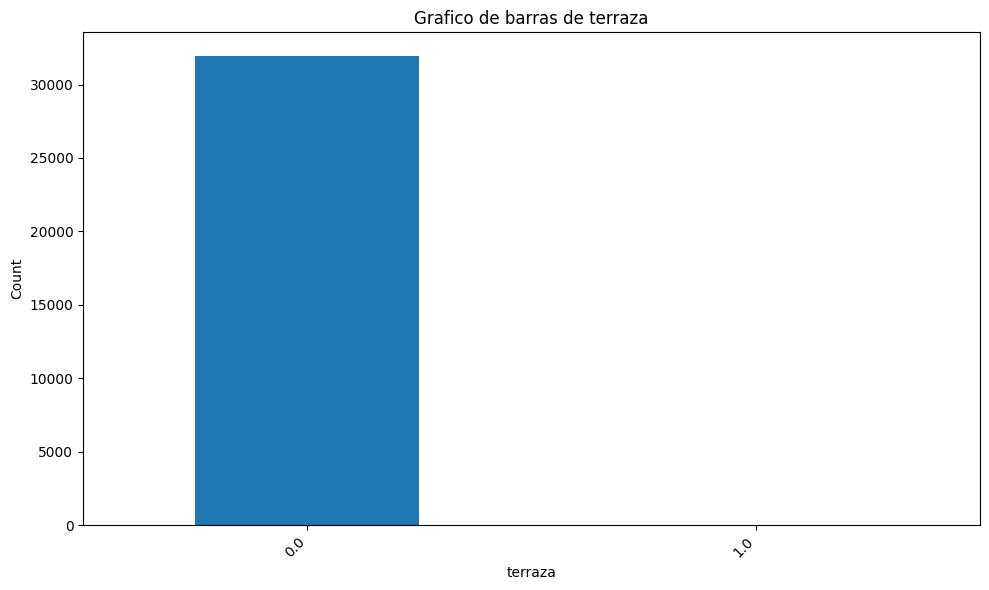

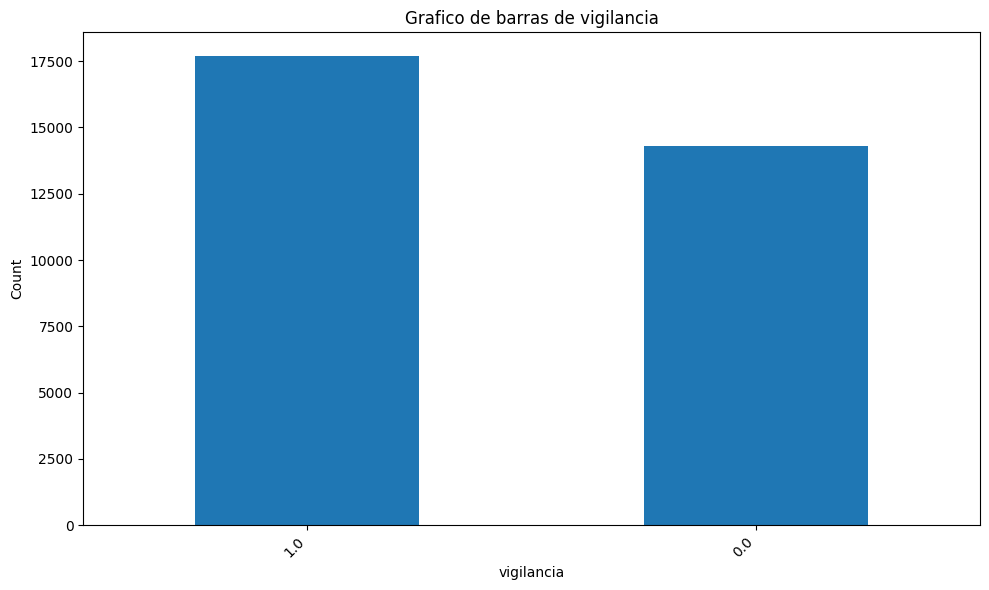

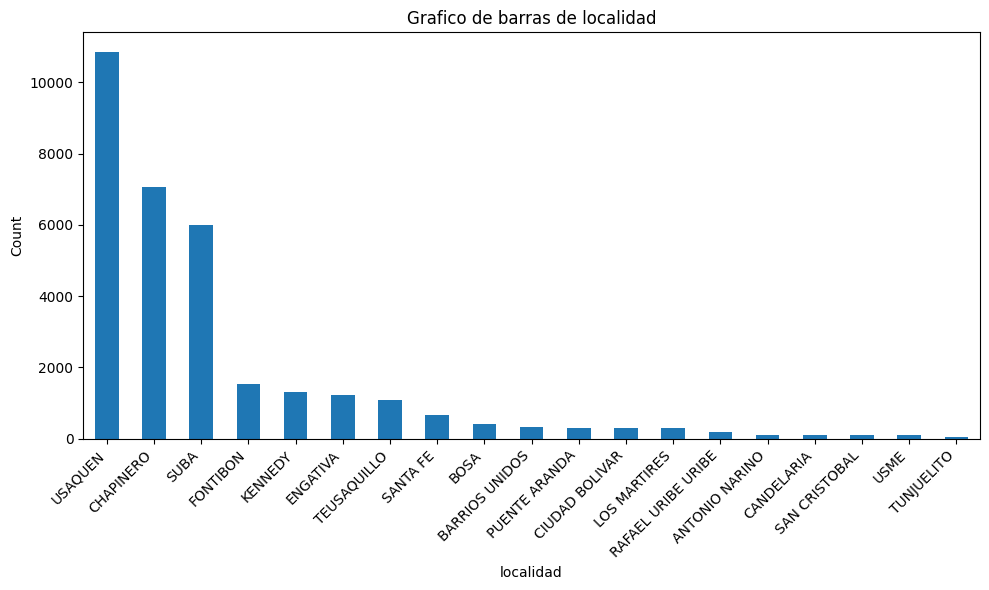

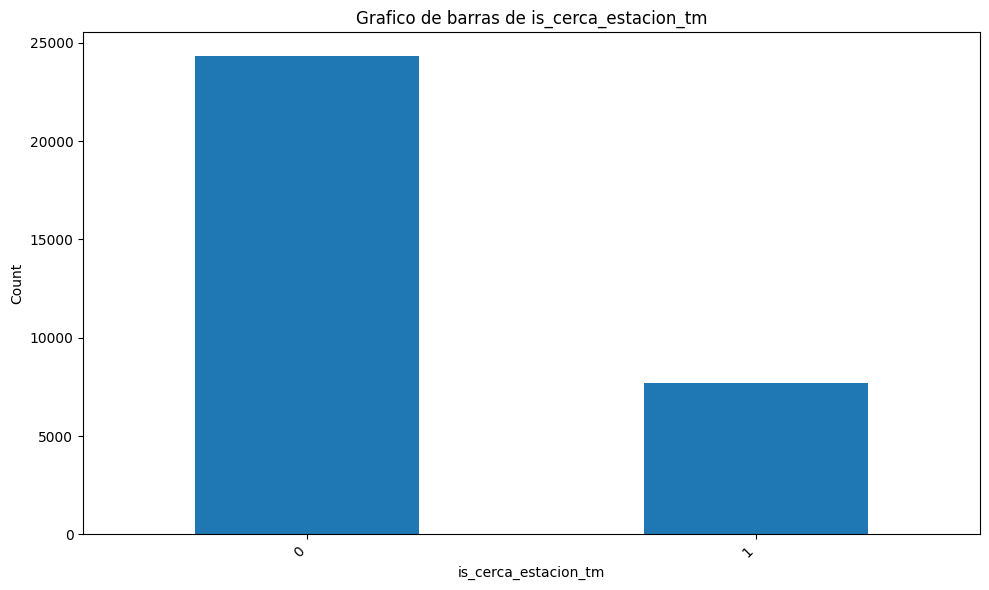

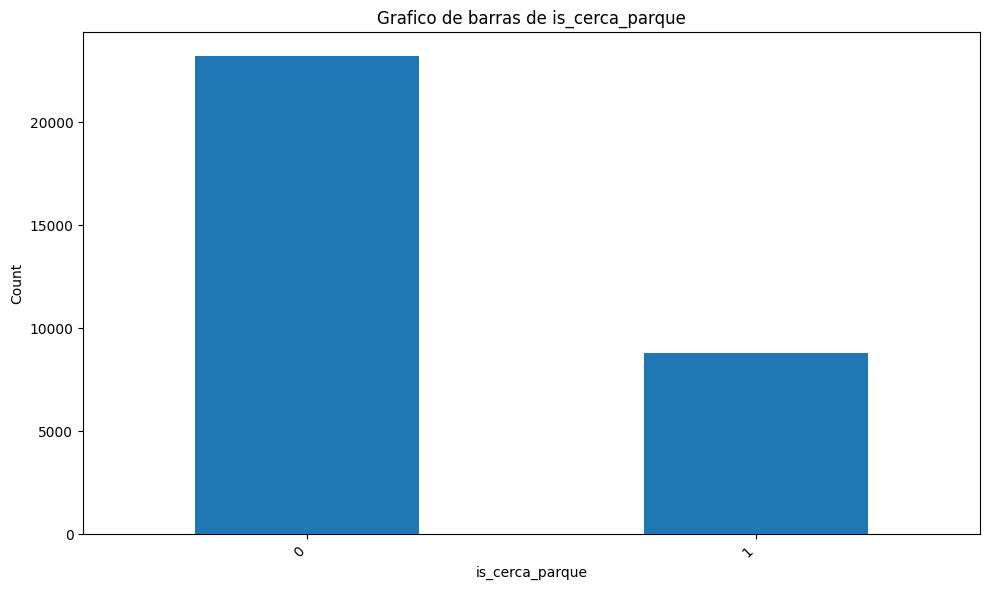

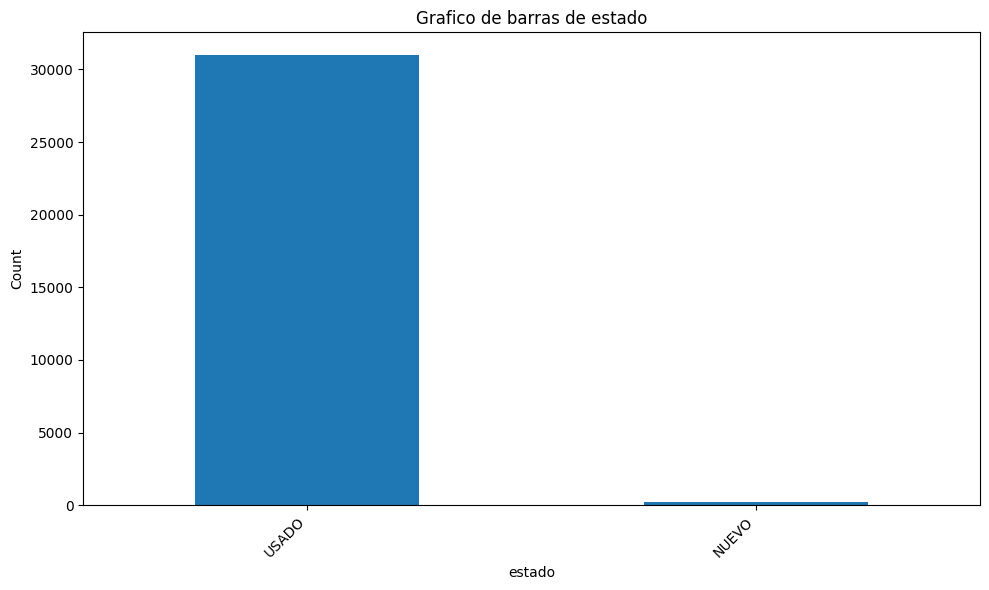

In [ ]:
cols = ['sector', 'barrio', 'estacion_tm_cercana']
for i in cols:
  property_type_counts = df[i].value_counts()
  top_20_property_types = property_type_counts.head(20)
  plt.figure(figsize=(12, 6))
  top_20_property_types.plot(kind='bar')
  plt.title(f'Top 20 {i}')
  plt.xlabel(i)
  plt.ylabel('Cantidad')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

parque_cercano_counts = df['parque_cercano'].value_counts()
top_20_parques = parque_cercano_counts.head(20)
plt.figure(figsize=(12, 6))
top_20_parques.plot(kind='barh')
plt.title('Top 20 Parques Cercanos')
plt.xlabel('Cantidad')
plt.ylabel('Parque Cercano')
plt.tight_layout()
plt.show()

#Se procede a realizar la grafica de barras para aquellas columnas que sean categoricas

cols = ['tipo_propiedad', 'tipo_operacion', 'antiguedad', 'jacuzzi', 'gimnasio', 'ascensor',
    'conjunto_cerrado' , 'piscina', 'terraza', 'vigilancia', 'localidad', 'is_cerca_estacion_tm', 'is_cerca_parque', 'estado']

for col in cols:
  plt.figure(figsize=(10, 6))
  df[col].value_counts().plot(kind='bar')
  plt.title(f'Grafico de barras de {col}')
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

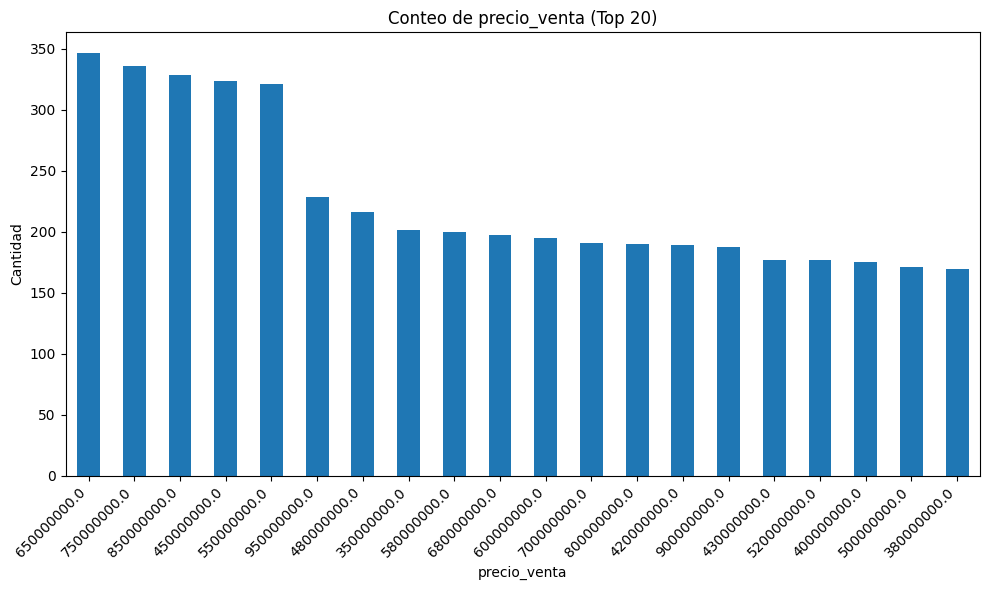

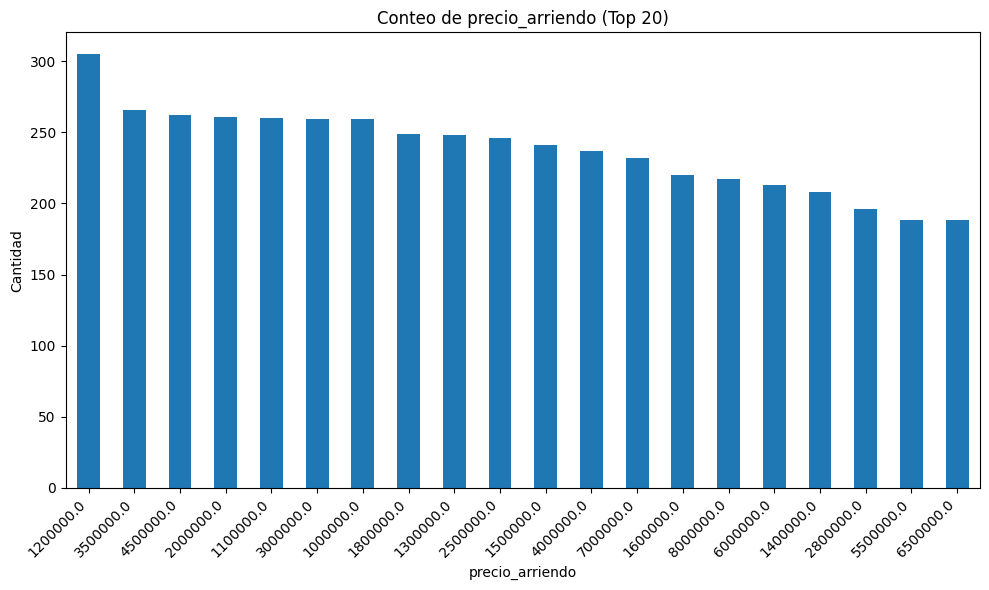

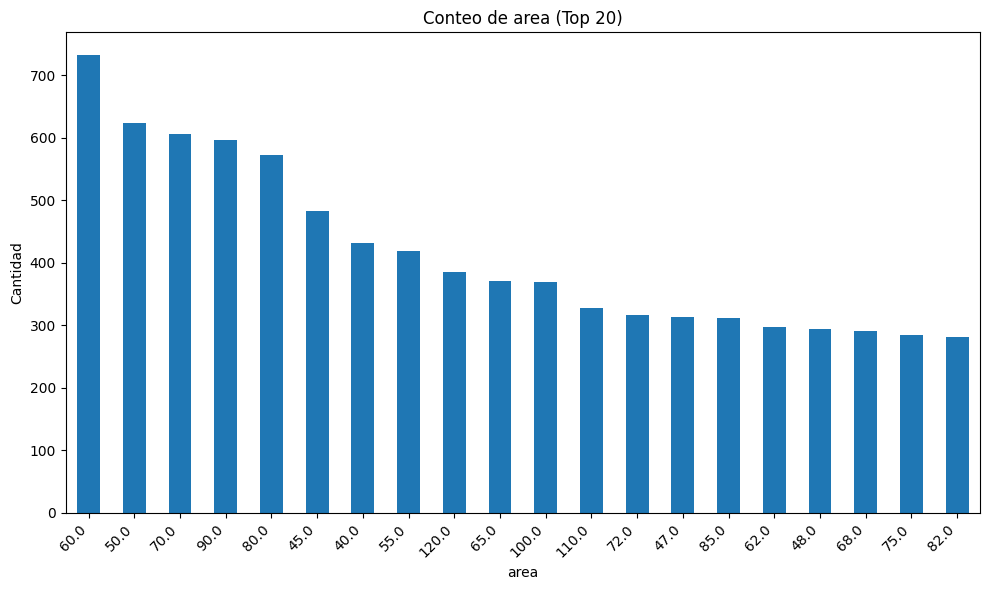

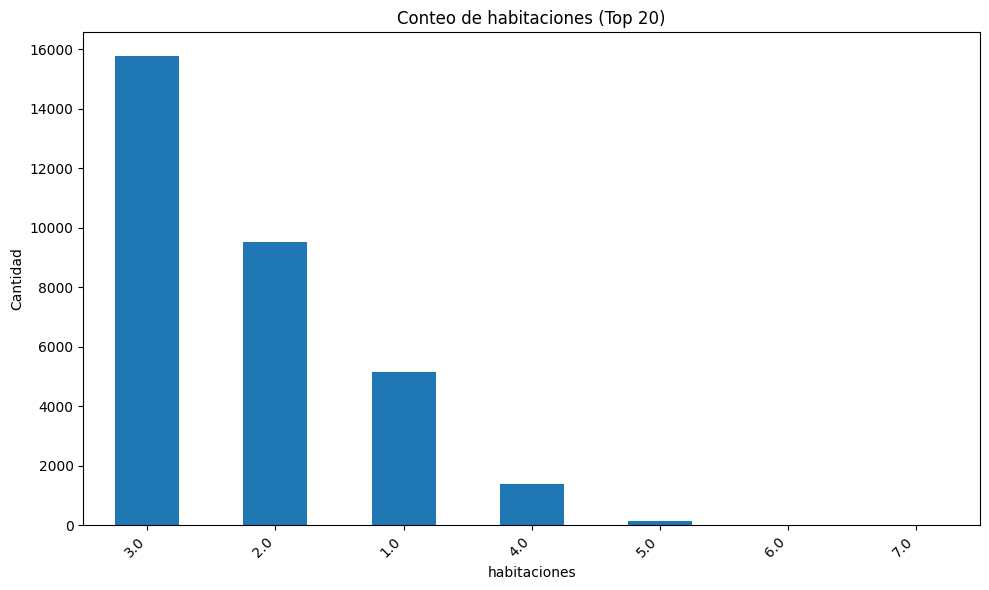

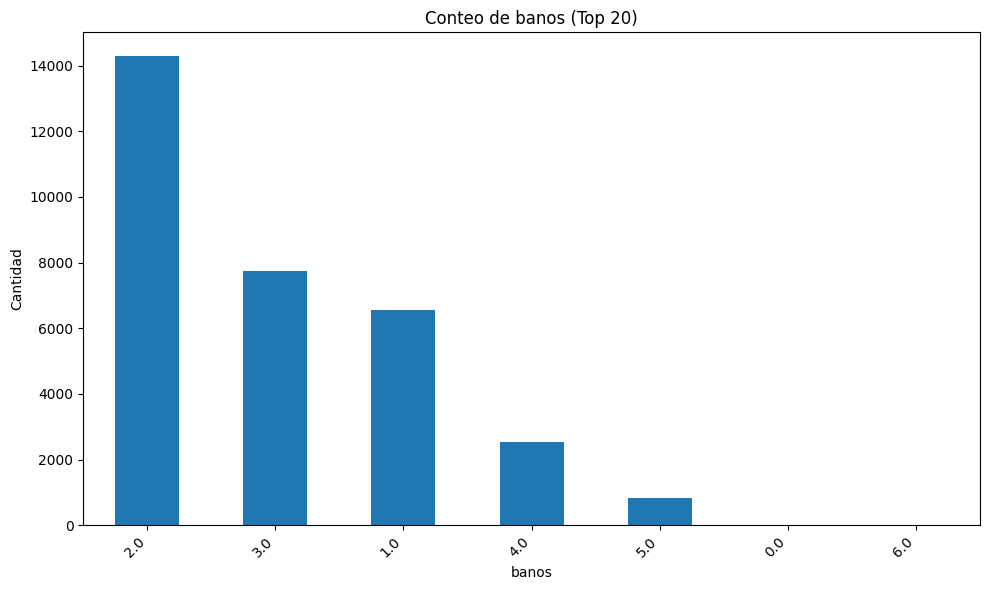

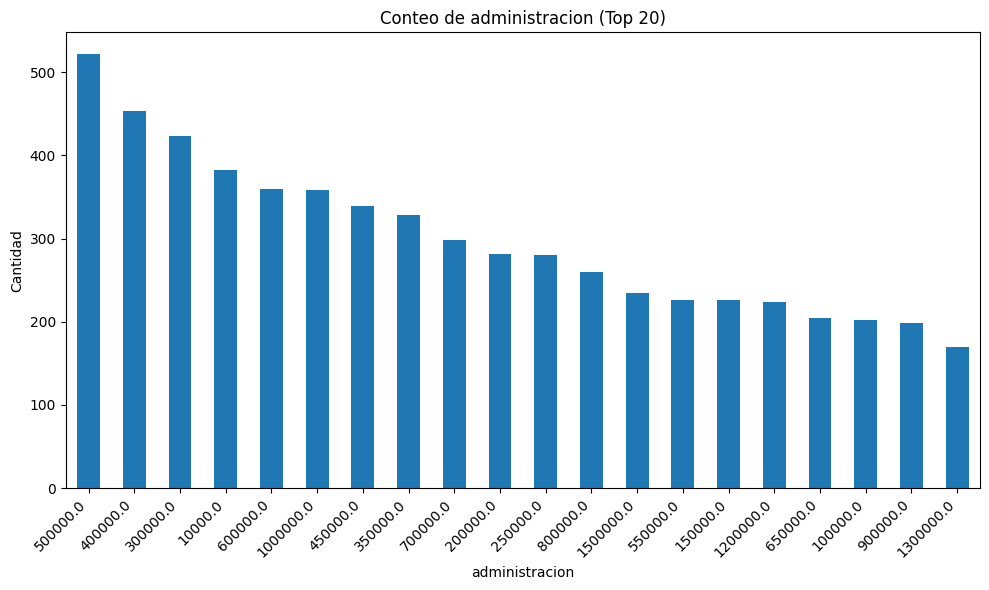

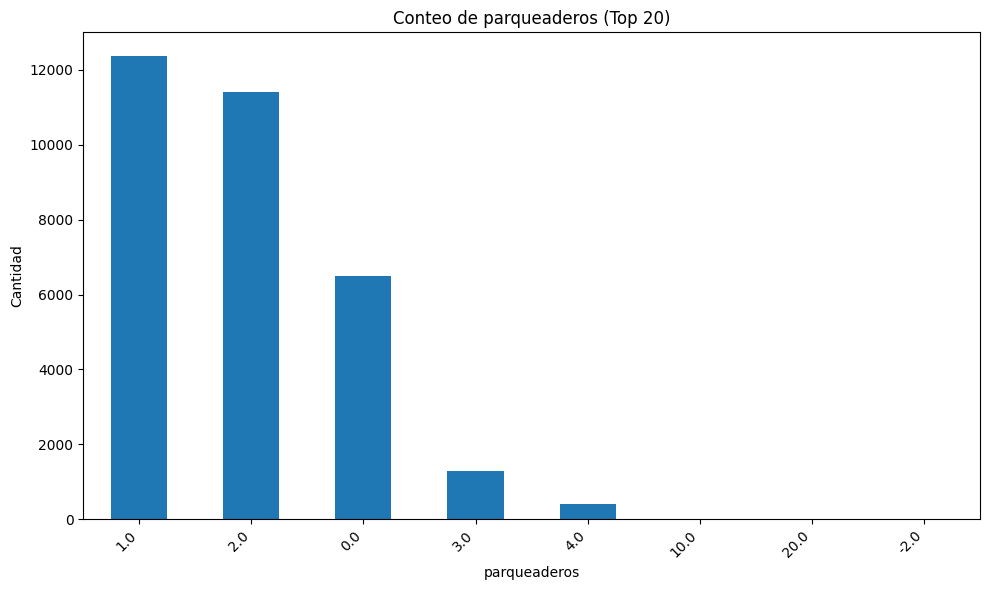

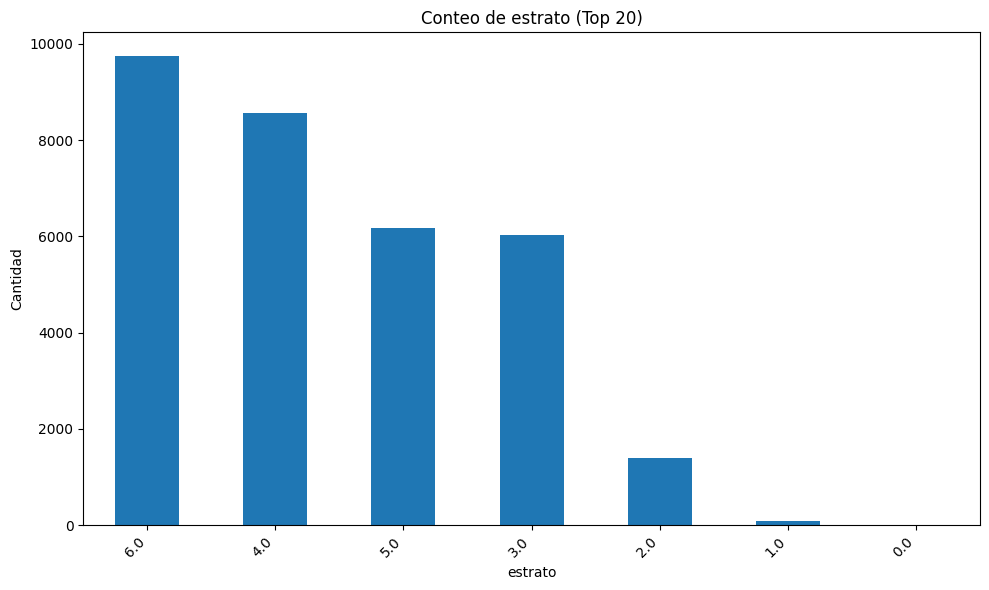

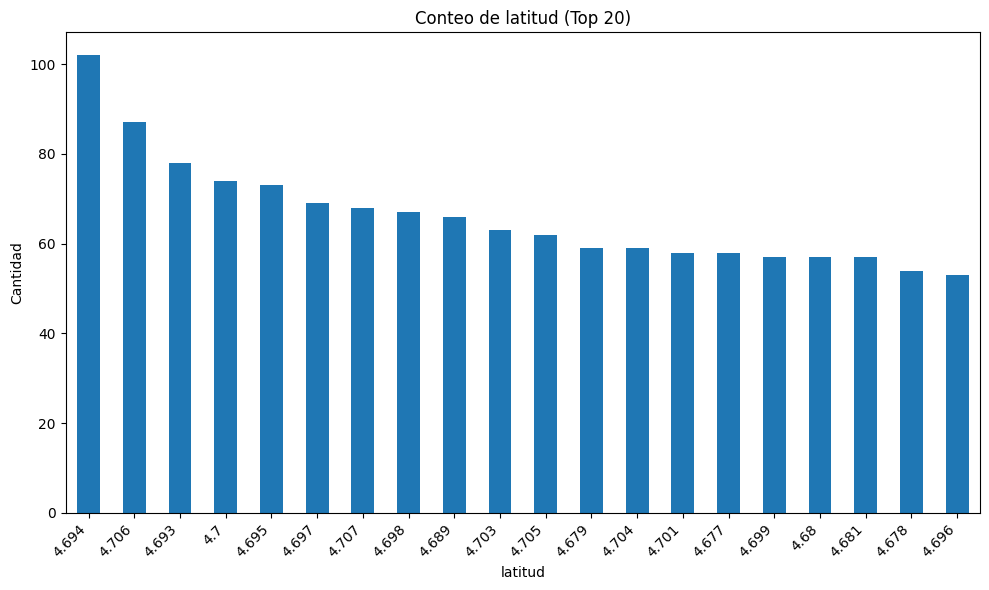

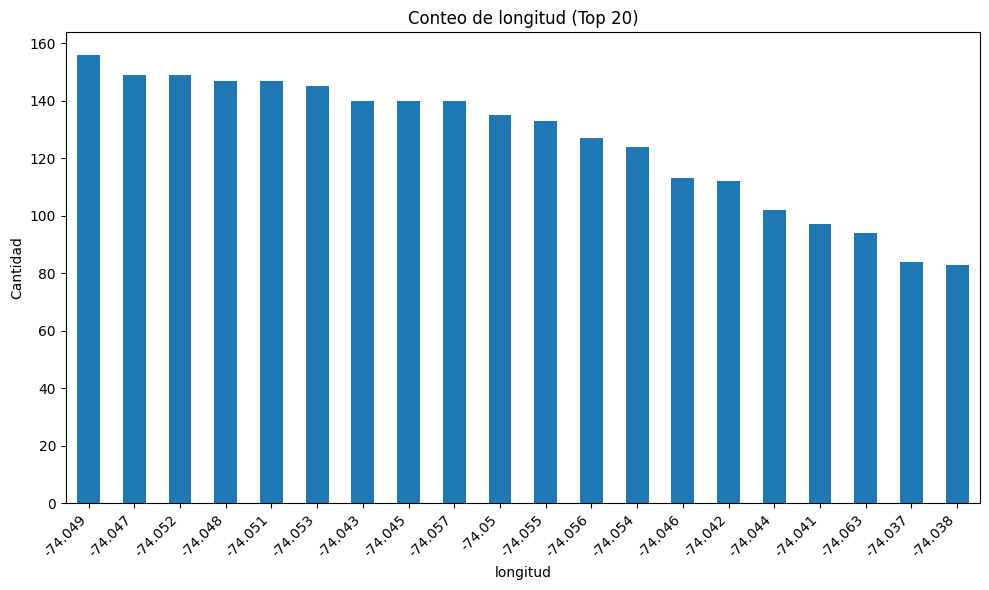

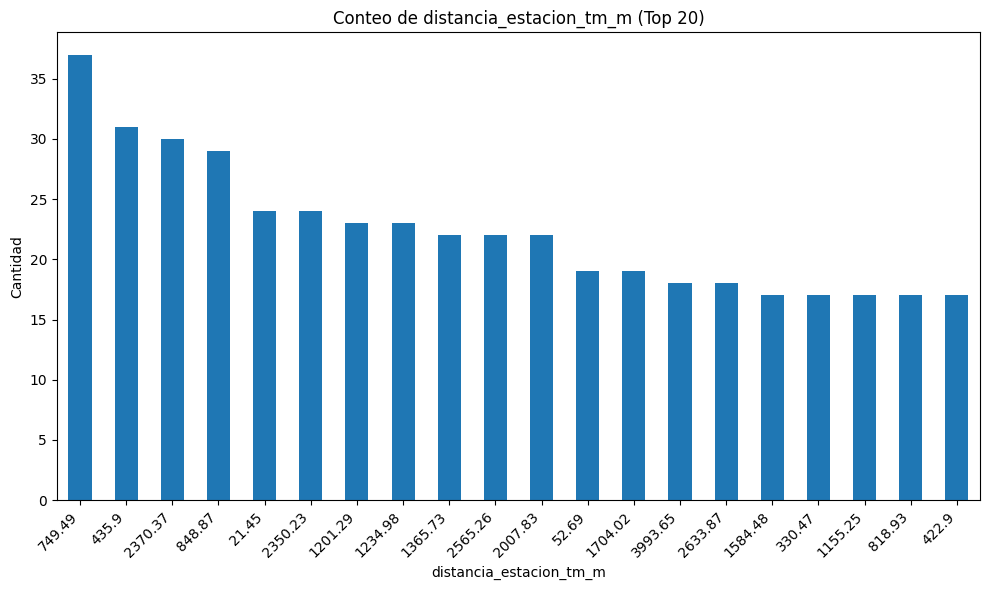

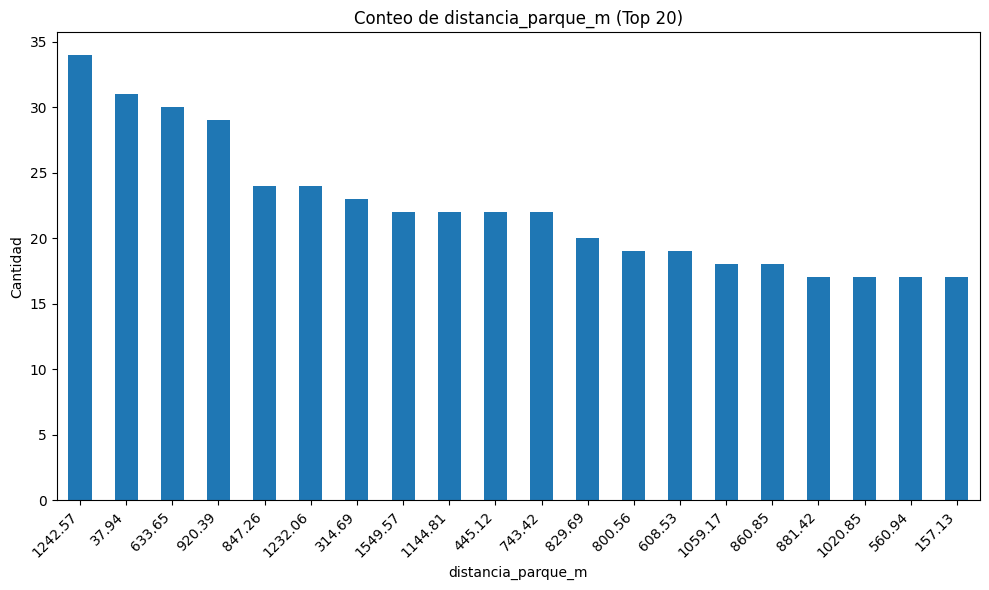

In [ ]:
#Se procede a mirar graficamente el metodo de imputacion
cols = ['precio_venta', 'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos', 'estrato', 'latitud', 'longitud',
  'distancia_estacion_tm_m', 'distancia_parque_m']
for i in cols:
  plt.figure(figsize=(10, 6))
  df[i].value_counts().head(20).plot(kind='bar')
  plt.title(f'Conteo de {i} (Top 20)')
  plt.xlabel(i)
  plt.ylabel('Cantidad')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

In [ ]:
#Se tomo la media como metodo de imputacion para los numericos y la moda para los categoricos
numerico = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

nominal = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehotEncoder', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
#La variable a predecir es estrato
preprocessor = ColumnTransformer([
    ('numerico', numerico, ['precio_venta', 'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos', 'latitud', 'longitud',
                            'distancia_estacion_tm_m', 'distancia_parque_m']),
    ('nominal', nominal, ['tipo_operacion', 'antiguedad', 'jacuzzi', 'gimnasio', 'ascensor', 'sector', 'barrio', 'estacion_tm_cercana', 'parque_cercano',
                          'conjunto_cerrado' , 'piscina', 'vigilancia', 'localidad', 'is_cerca_estacion_tm', 'is_cerca_parque', 'estado', 'tipo_propiedad',
                           'terraza'])
])

In [ ]:
#Generamos el modelo KNN pasandole el column transformer
KNN = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=10))
])

KNN

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerico',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['precio_venta',
                                                   'precio_arriendo', 'area',
                                                   'habitaciones', 'banos',
                                                   'administracion',
                                                   'parqueaderos', 'latitud',
                                                   'longitud',
                                                   'distancia_estacion_tm_m',
                                                   'distancia_parque_m']),
                                                 ('nominal',
                                                  Pipeli...
                                                                  ('onehotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tipo_operacion',
                                                   'antiguedad', 'jacuzzi',
                                                   'gimnasio', 'ascensor',
                                                   'sector', 'barrio',
                                                   'estacion_tm_cercana',
                                                   'parque_cercano',
                                                   'conjunto_cerrado',
                                                   'piscina', 'vigilancia',
                                                   'localidad',
                                                   'is_cerca_estacion_tm',
                                                   'is_cerca_parque', 'estado',
                                                   'tipo_propiedad',
                                                   'terraza'])])),
                ('model', KNeighborsRegressor(n_neighbors=10))])

In [ ]:
#Generamos el modelo LinearRegressor pasandole el column transformer
linear = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linear

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerico',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['precio_venta',
                                                   'precio_arriendo', 'area',
                                                   'habitaciones', 'banos',
                                                   'administracion',
                                                   'parqueaderos', 'latitud',
                                                   'longitud',
                                                   'distancia_estacion_tm_m',
                                                   'distancia_parque_m']),
                                                 ('nominal',
                                                  Pipeli...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tipo_operacion',
                                                   'antiguedad', 'jacuzzi',
                                                   'gimnasio', 'ascensor',
                                                   'sector', 'barrio',
                                                   'estacion_tm_cercana',
                                                   'parque_cercano',
                                                   'conjunto_cerrado',
                                                   'piscina', 'vigilancia',
                                                   'localidad',
                                                   'is_cerca_estacion_tm',
                                                   'is_cerca_parque', 'estado',
                                                   'tipo_propiedad',
                                                   'terraza'])])),
                ('model', LinearRegression())])

In [ ]:
#Generamos el modelo RandomForestRegressor pasandole el column transformer
RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(max_depth=20))
])

RandomForest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerico',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['precio_venta',
                                                   'precio_arriendo', 'area',
                                                   'habitaciones', 'banos',
                                                   'administracion',
                                                   'parqueaderos', 'latitud',
                                                   'longitud',
                                                   'distancia_estacion_tm_m',
                                                   'distancia_parque_m']),
                                                 ('nominal',
                                                  Pipeli...
                                                                  ('onehotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tipo_operacion',
                                                   'antiguedad', 'jacuzzi',
                                                   'gimnasio', 'ascensor',
                                                   'sector', 'barrio',
                                                   'estacion_tm_cercana',
                                                   'parque_cercano',
                                                   'conjunto_cerrado',
                                                   'piscina', 'vigilancia',
                                                   'localidad',
                                                   'is_cerca_estacion_tm',
                                                   'is_cerca_parque', 'estado',
                                                   'tipo_propiedad',
                                                   'terraza'])])),
                ('model', RandomForestRegressor(max_depth=20))])

In [ ]:
X_train = train.drop('estrato', axis=1)
y_train = train['estrato']
y_train.fillna(y_train.median(), inplace=True)

X_test = test.drop('estrato', axis=1)
y_test = test['estrato']

In [ ]:
KNN.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerico',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['precio_venta',
                                                   'precio_arriendo', 'area',
                                                   'habitaciones', 'banos',
                                                   'administracion',
                                                   'parqueaderos', 'latitud',
                                                   'longitud',
                                                   'distancia_estacion_tm_m',
                                                   'distancia_parque_m']),
                                                 ('nominal',
                                                  Pipeli...
                                                                  ('onehotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tipo_operacion',
                                                   'antiguedad', 'jacuzzi',
                                                   'gimnasio', 'ascensor',
                                                   'sector', 'barrio',
                                                   'estacion_tm_cercana',
                                                   'parque_cercano',
                                                   'conjunto_cerrado',
                                                   'piscina', 'vigilancia',
                                                   'localidad',
                                                   'is_cerca_estacion_tm',
                                                   'is_cerca_parque', 'estado',
                                                   'tipo_propiedad',
                                                   'terraza'])])),
                ('model', KNeighborsRegressor(n_neighbors=10))])

In [ ]:
linear.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerico',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['precio_venta',
                                                   'precio_arriendo', 'area',
                                                   'habitaciones', 'banos',
                                                   'administracion',
                                                   'parqueaderos', 'latitud',
                                                   'longitud',
                                                   'distancia_estacion_tm_m',
                                                   'distancia_parque_m']),
                                                 ('nominal',
                                                  Pipeli...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tipo_operacion',
                                                   'antiguedad', 'jacuzzi',
                                                   'gimnasio', 'ascensor',
                                                   'sector', 'barrio',
                                                   'estacion_tm_cercana',
                                                   'parque_cercano',
                                                   'conjunto_cerrado',
                                                   'piscina', 'vigilancia',
                                                   'localidad',
                                                   'is_cerca_estacion_tm',
                                                   'is_cerca_parque', 'estado',
                                                   'tipo_propiedad',
                                                   'terraza'])])),
                ('model', LinearRegression())])

In [ ]:
RandomForest.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerico',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['precio_venta',
                                                   'precio_arriendo', 'area',
                                                   'habitaciones', 'banos',
                                                   'administracion',
                                                   'parqueaderos', 'latitud',
                                                   'longitud',
                                                   'distancia_estacion_tm_m',
                                                   'distancia_parque_m']),
                                                 ('nominal',
                                                  Pipeli...
                                                                  ('onehotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tipo_operacion',
                                                   'antiguedad', 'jacuzzi',
                                                   'gimnasio', 'ascensor',
                                                   'sector', 'barrio',
                                                   'estacion_tm_cercana',
                                                   'parque_cercano',
                                                   'conjunto_cerrado',
                                                   'piscina', 'vigilancia',
                                                   'localidad',
                                                   'is_cerca_estacion_tm',
                                                   'is_cerca_parque', 'estado',
                                                   'tipo_propiedad',
                                                   'terraza'])])),
                ('model', RandomForestRegressor(max_depth=20))])

In [ ]:
y_pred_knn = KNN.predict(X_test)

y_pred_linear = linear.predict(X_test)

y_pred_rf = RandomForest.predict(X_test)

In [ ]:
y_test.fillna(y_test.median(), inplace=True)

KNN Train: MAE=0.19, MSE=0.14, RMSE=0.37, R2=0.91
Linear Train: MAE=0.23, MSE=0.16, RMSE=0.40, R2=0.90
Random Forest Train: MAE=0.11, MSE=0.06, RMSE=0.24, R2=0.96
KNN Test: MAE=0.22, MSE=0.18, RMSE=0.43, R2=0.88
Linear Test: MAE=0.25, MSE=0.20, RMSE=0.45, R2=0.87
Random Forest Test: MAE=0.20, MSE=0.16, RMSE=0.40, R2=0.89


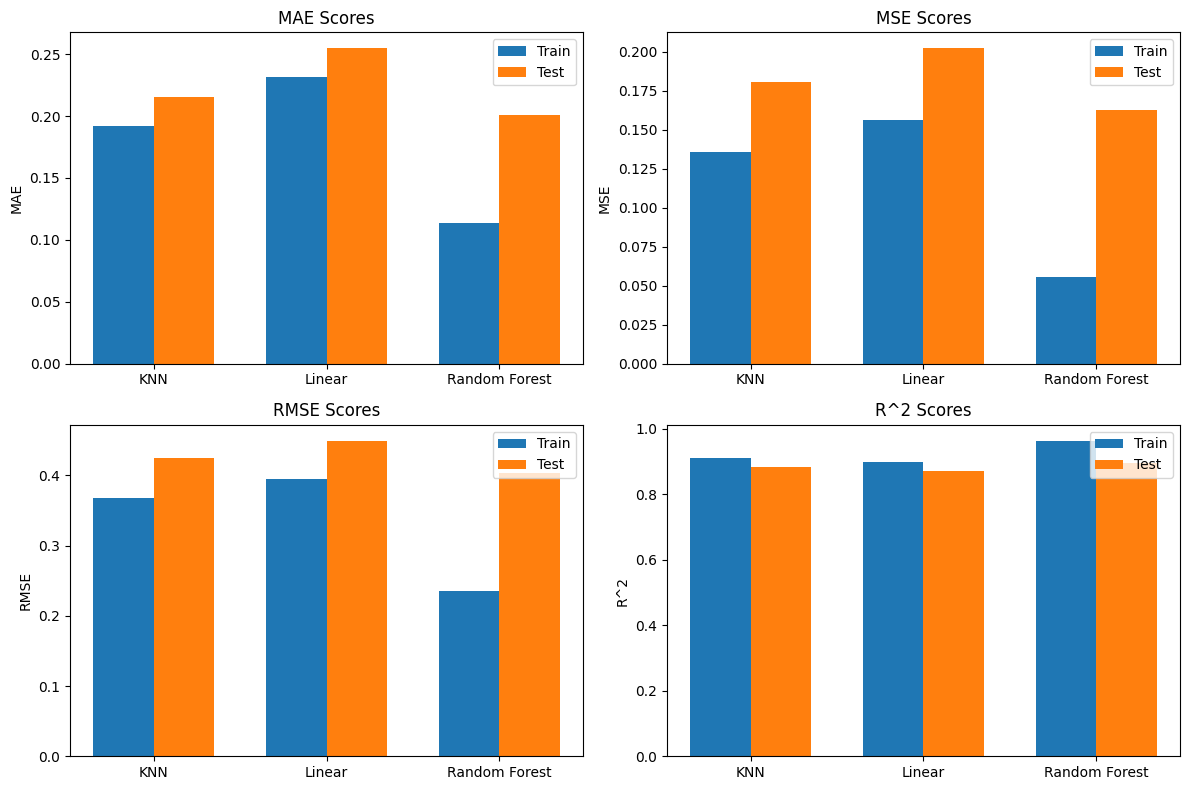

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Calculate MAE, MSE, RMSE, and R-squared for each model
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

#Train Errors
mae_knn_train, mse_knn_train, rmse_knn_train, r2_knn_train = evaluate_model(y_train, KNN.predict(X_train), "KNN")
mae_linear_train, mse_linear_train, rmse_linear_train, r2_linear_train = evaluate_model(y_train, linear.predict(X_train), "Linear")
mae_rf_train, mse_rf_train, rmse_rf_train, r2_rf_train = evaluate_model(y_train, RandomForest.predict(X_train), "Random Forest")


#Test Errors
mae_knn, mse_knn, rmse_knn, r2_knn = evaluate_model(y_test, y_pred_knn, "KNN")
mae_linear, mse_linear, rmse_linear, r2_linear = evaluate_model(y_test, y_pred_linear, "Linear")
mae_rf, mse_rf, rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")


# Print the results
print("KNN Train: MAE={:.2f}, MSE={:.2f}, RMSE={:.2f}, R2={:.2f}".format(mae_knn_train, mse_knn_train, rmse_knn_train, r2_knn_train))
print("Linear Train: MAE={:.2f}, MSE={:.2f}, RMSE={:.2f}, R2={:.2f}".format(mae_linear_train, mse_linear_train, rmse_linear_train, r2_linear_train))
print("Random Forest Train: MAE={:.2f}, MSE={:.2f}, RMSE={:.2f}, R2={:.2f}".format(mae_rf_train, mse_rf_train, rmse_rf_train, r2_rf_train))

print("KNN Test: MAE={:.2f}, MSE={:.2f}, RMSE={:.2f}, R2={:.2f}".format(mae_knn, mse_knn, rmse_knn, r2_knn))
print("Linear Test: MAE={:.2f}, MSE={:.2f}, RMSE={:.2f}, R2={:.2f}".format(mae_linear, mse_linear, rmse_linear, r2_linear))
print("Random Forest Test: MAE={:.2f}, MSE={:.2f}, RMSE={:.2f}, R2={:.2f}".format(mae_rf, mse_rf, rmse_rf, r2_rf))


# Create a bar chart to compare train and test errors
labels = ['KNN', 'Linear', 'Random Forest']
mae_train = [mae_knn_train, mae_linear_train, mae_rf_train]
mae_test = [mae_knn, mae_linear, mae_rf]
mse_train = [mse_knn_train, mse_linear_train, mse_rf_train]
mse_test = [mse_knn, mse_linear, mse_rf]
rmse_train = [rmse_knn_train, rmse_linear_train, rmse_rf_train]
rmse_test = [rmse_knn, rmse_linear, rmse_rf]
r2_train = [r2_knn_train, r2_linear_train, r2_rf_train]
r2_test = [r2_knn, r2_linear, r2_rf]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].bar(x - width/2, mae_train, width, label='Train')
axes[0,0].bar(x + width/2, mae_test, width, label='Test')
axes[0,0].set_ylabel('MAE')
axes[0,0].set_title('MAE Scores')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(labels)
axes[0,0].legend()

axes[0,1].bar(x - width/2, mse_train, width, label='Train')
axes[0,1].bar(x + width/2, mse_test, width, label='Test')
axes[0,1].set_ylabel('MSE')
axes[0,1].set_title('MSE Scores')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(labels)
axes[0,1].legend()

axes[1,0].bar(x - width/2, rmse_train, width, label='Train')
axes[1,0].bar(x + width/2, rmse_test, width, label='Test')
axes[1,0].set_ylabel('RMSE')
axes[1,0].set_title('RMSE Scores')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(labels)
axes[1,0].legend()

axes[1,1].bar(x - width/2, r2_train, width, label='Train')
axes[1,1].bar(x + width/2, r2_test, width, label='Test')
axes[1,1].set_ylabel('R^2')
axes[1,1].set_title('R^2 Scores')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(labels)
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Preguntas

Variables que se van a explicar mediante preguntas claves:

* Precio arriendo
* Precio venta
* Sector
* Tipo operacion
* Estrato
* Barrio
* Estacion tm cercanas
* Parques cercanos

Preguntas

¿Dónde se ubican las propiedades que tienen vigilancia, y cómo influye en el precio del arriendo o venta?

In [ ]:
vigilancia_coords = df[df['vigilancia'] == 1][['latitud', 'longitud']].dropna().values.tolist()

# Crear el mapa de bogota
bogota_map = folium.Map(location=[4.6097, -74.0817], zoom_start=12)

# Añadir al mapa de bogota el mapa de calor el cual filtra los inmuebles que tienen vigilancia
HeatMap(vigilancia_coords).add_to(bogota_map)

#Mostrar el mapa
bogota_map

  vigilancia  Precio Arriendo Promedio  Precio Venta Promedio
0         Sí              4.756706e+06           5.521805e+08
1         No              3.865002e+06           4.570807e+08


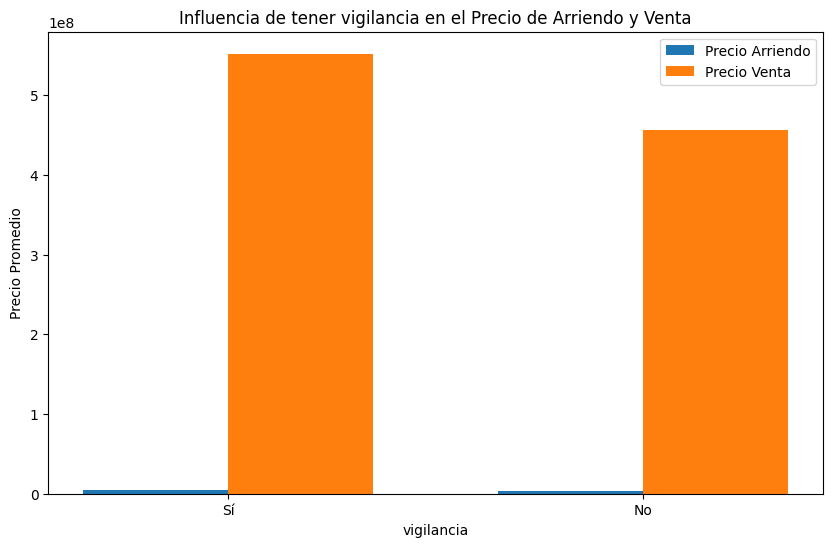

In [ ]:
df_vigilancia = df[df['vigilancia'] == 1]
df_no_vigilancia = df[df['vigilancia'] == 0]

# Calcular la media del precio de arriendo y venta para ambos grupos
precio_promedio_vigilancia = df_vigilancia[['precio_arriendo', 'precio_venta']].mean()
precio_promedio_no_vigilancia = df_no_vigilancia[['precio_arriendo', 'precio_venta']].mean()

# Crear un DataFrame con los resultados
resultados = pd.DataFrame({
    'vigilancia': ['Sí', 'No'],
    'Precio Arriendo Promedio': [precio_promedio_vigilancia['precio_arriendo'], precio_promedio_no_vigilancia['precio_arriendo']],
    'Precio Venta Promedio': [precio_promedio_vigilancia['precio_venta'], precio_promedio_no_vigilancia['precio_venta']]
})

# Mostrar el DataFrame
print(resultados)

# Crear un gráfico de barras para comparar los precios promedio
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)

plt.bar(index, resultados['Precio Arriendo Promedio'], bar_width, label='Precio Arriendo')
plt.bar(index + bar_width, resultados['Precio Venta Promedio'], bar_width, label='Precio Venta')

plt.xlabel('vigilancia')
plt.ylabel('Precio Promedio')
plt.title('Influencia de tener vigilancia en el Precio de Arriendo y Venta')
plt.xticks(index + bar_width / 2, resultados['vigilancia'])
plt.legend()
plt.show()

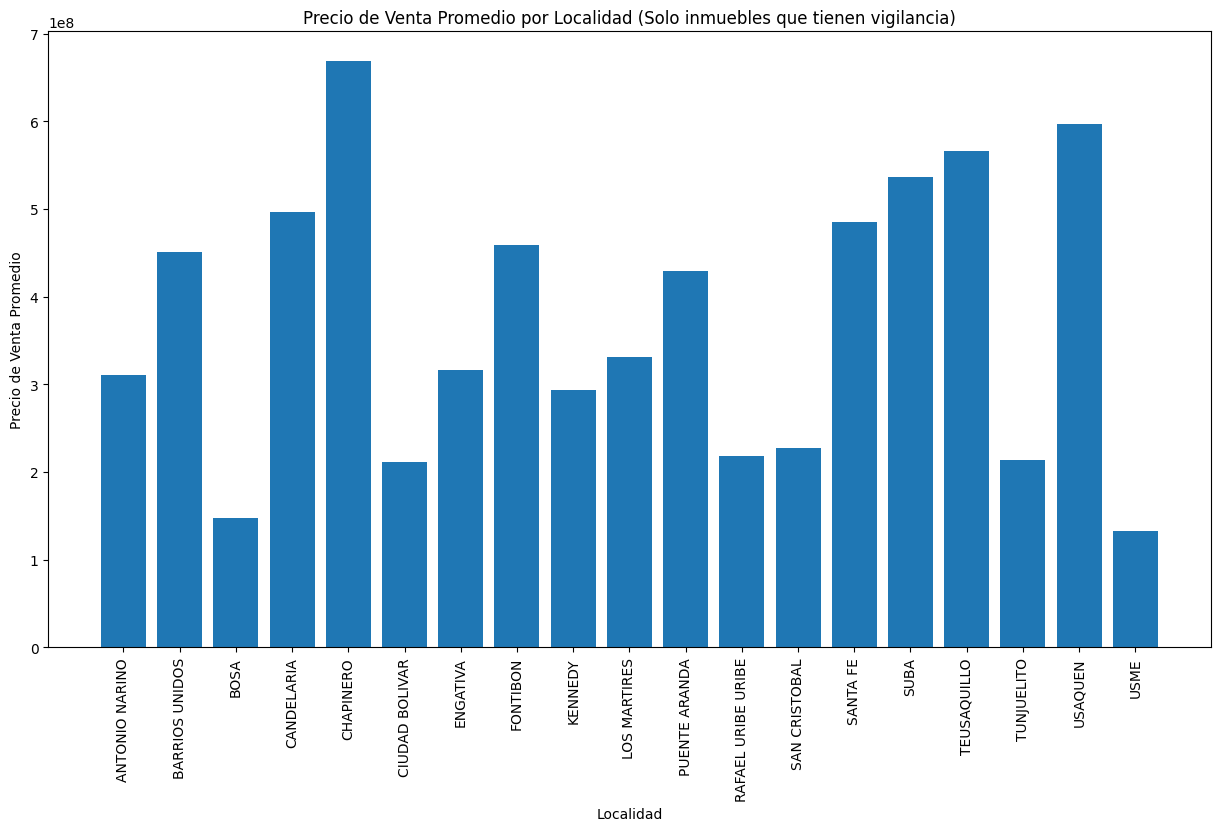

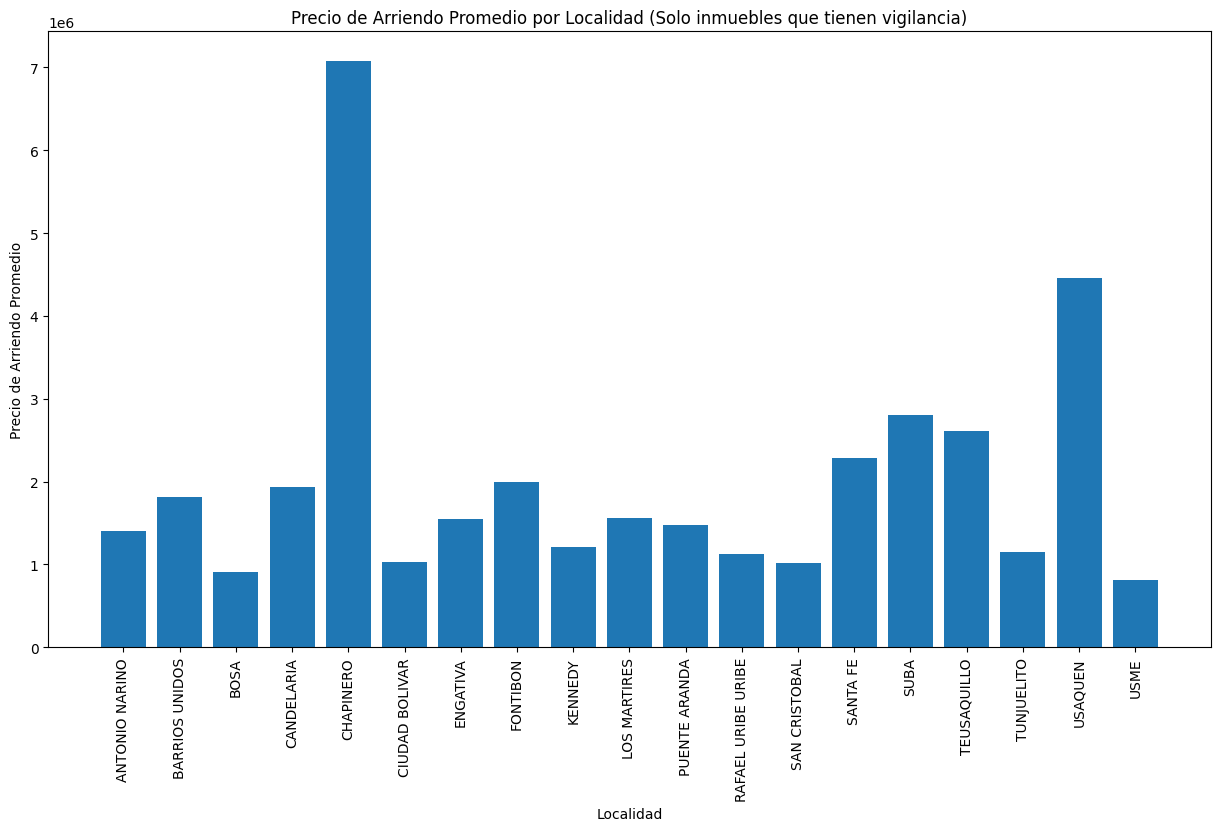

In [ ]:
# Agrupar los datos por localidad y permitir mascotas, calcular la media del precio de venta y arriendo
grouped_data = df[df['vigilancia'] == 1].groupby(['localidad'])[['precio_venta', 'precio_arriendo']].mean().reset_index()

# Crear el gráfico de barras para el precio de venta
plt.figure(figsize=(15, 8))
plt.bar(grouped_data['localidad'], grouped_data['precio_venta'])
plt.xlabel('Localidad')
plt.ylabel('Precio de Venta Promedio')
plt.title('Precio de Venta Promedio por Localidad (Solo inmuebles que tienen vigilancia)')
plt.xticks(rotation=90)
plt.show()


# Crear el gráfico de barras para el precio de arriendo
plt.figure(figsize=(15, 8))
plt.bar(grouped_data['localidad'], grouped_data['precio_arriendo'])
plt.xlabel('Localidad')
plt.ylabel('Precio de Arriendo Promedio')
plt.title('Precio de Arriendo Promedio por Localidad (Solo inmuebles que tienen vigilancia)')
plt.xticks(rotation=90)
plt.show()


Conclusiones

1.  Ciudad Bolívar destaca con un precio promedio muy elevado, mucho más que el resto de las localidades. Esto sugiere que, en esta localidad, las propiedades con vigilancia podrían estar en zonas con altos estándares de seguridad o en sectores de alta demanda.

2.  Localidades como Bosa, Usaquén, y Usme muestran precios de arriendo relativamente bajos para propiedades con vigilancia, lo que podría indicar que, aunque cuenten con seguridad, la demanda o el tipo de propiedades ofertadas en estas zonas no logra alcanzar precios altos.

3. Hay una cantidad significativa de localidades con precios de arriendo promedio que están en rangos medios, como Fontibón, Kennedy y Tunjuelito. Esto puede indicar una oferta de propiedades con vigilancia orientada a segmentos de ingresos medios.

4.  La seguridad parece ser un factor importante en los precios, ya que en localidades como Ciudad Bolívar, Chapinero y Usaquén, donde se suele asociar una mayor demanda de seguridad, se observa una diferencia considerable en los precios, sugiriendo que la vigilancia puede incrementar el valor de las propiedades en áreas donde la seguridad es más valorada.

En conclusión, la ubicación de propiedades con vigilancia influye notablemente en el precio de arriendo y venta en algunas localidades, la presencia de vigilancia parece justificar un precio más alto, mientras que en otras, la seguridad añadida no tiene el mismo impacto en el precio

¿Cuáles son las localidades o sectores con mayor concentración de viviendas en estratos altos o bajos?

In [ ]:
# Filtrar los datos para estratos mayores a 4
df_estrato_alto = df[df['estrato'] > 4]

# Obtener las coordenadas de las viviendas con estrato alto
heat_data = df_estrato_alto[['latitud', 'longitud']].dropna().values.tolist()

# Crear el mapa de Bogotá
bogota_map = folium.Map(location=[4.6097, -74.0817], zoom_start=12)

# Agregar el mapa de calor al mapa de Bogotá
HeatMap(heat_data).add_to(bogota_map)

# Mostrar el mapa
bogota_map

In [ ]:
# Filtrar los datos para estratos menores o iguales a 4
df_estrato_alto = df[df['estrato'] <= 4]

# Obtener las coordenadas de las viviendas con estrato alto
heat_data = df_estrato_alto[['latitud', 'longitud']].dropna().values.tolist()

# Crear el mapa de Bogotá
bogota_map = folium.Map(location=[4.6097, -74.0817], zoom_start=12)

# Agregar el mapa de calor al mapa de Bogotá
HeatMap(heat_data).add_to(bogota_map)

# Mostrar el mapa
bogota_map

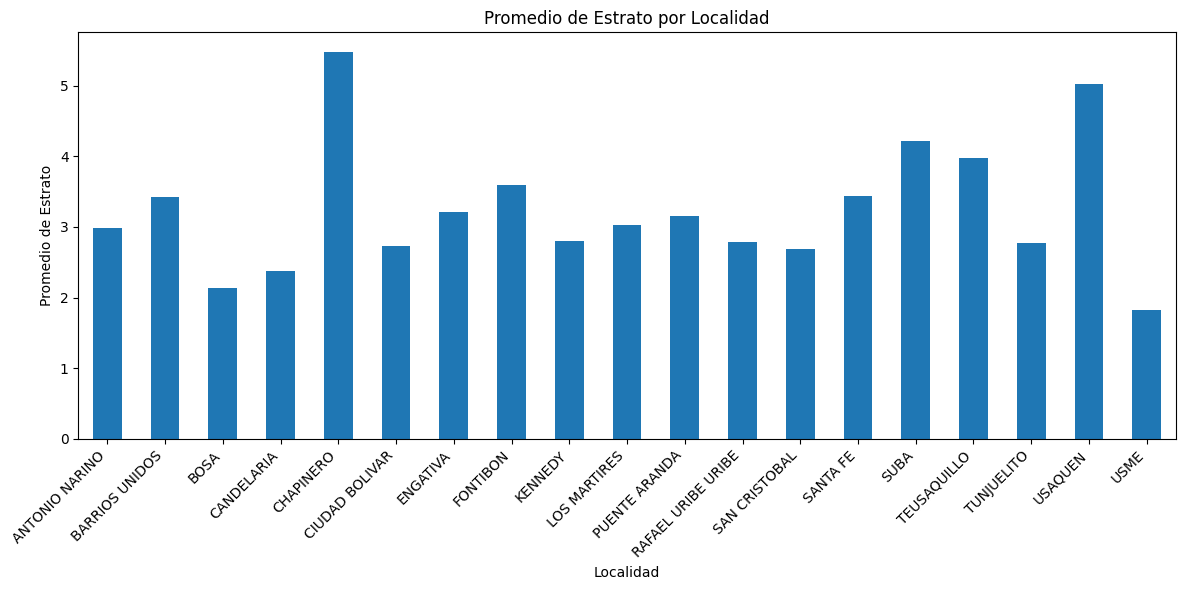

In [ ]:
# Agrupar los datos por localidad y estrato, calcular la media del estrato
estrato_promedio_por_localidad = df.groupby('localidad')['estrato'].mean()

# Crear un gráfico de barras para visualizar el promedio de estrato por localidad
plt.figure(figsize=(12, 6))
estrato_promedio_por_localidad.plot(kind='bar')
plt.xlabel('Localidad')
plt.ylabel('Promedio de Estrato')
plt.title('Promedio de Estrato por Localidad')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.tight_layout()
plt.show()

Conclusiones

1.  Chapinero y Usaquén presentan los promedios de estrato más altos entre las localidades, lo que indica una mayor concentración de viviendas de estratos altos, esto coincide con la percepción de que en estas áreas se encuentran zonas residenciales de mayor costo y prestigio en la ciudad.

2.  Usme, Candelaria y San Cristóbal tienen promedios de estrato más bajos, lo que indica una mayor concentración de viviendas en estratos bajos. Esto sugiere que estas localidades podrían albergar una mayor proporción de población con menor capacidad adquisitiva y con viviendas de menor costo.

3. Localidades como Fontibón, Kennedy y Suba tienen promedios de estrato en rangos medios, lo cual sugiere una diversidad de oferta de vivienda que abarca desde estratos bajos hasta medios-altos, permitiendo una mezcla socioeconómica variada.

4.  La distribución de los estratos en estas localidades sugiere una segmentación en la cual ciertas áreas se asocian a estratos más altos o bajos, influyendo posiblemente en factores como el acceso a servicios, seguridad y precios de arriendo o venta de inmuebles.

En conclusión, localidades como Chapinero y Usaquén tienen una alta concentración de viviendas en estratos altos, mientras que Usme, Candelaria y San Cristóbal muestran una mayor concentración de estratos bajos, evidenciando una marcada diferenciación socioeconómica entre las áreas urbanas.

¿Cómo se distribuyen los precios de venta y arriendo según la localización
geográfica?

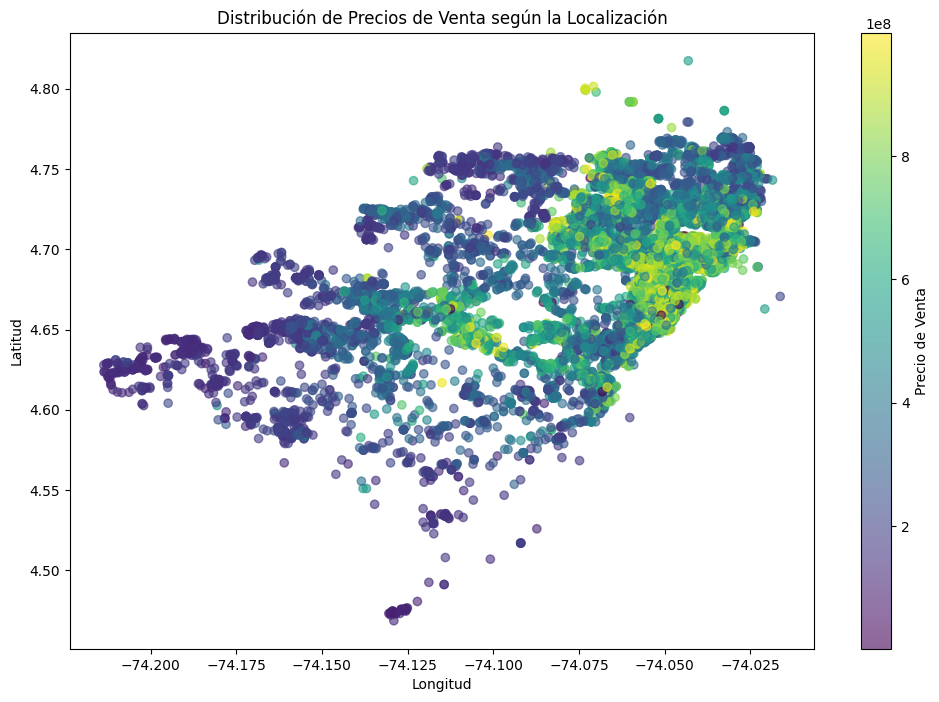

In [ ]:
# Crear un gráfico de dispersión para visualizar la relación entre la latitud, longitud y el precio de venta
plt.figure(figsize=(12, 8))
plt.scatter(df['longitud'], df['latitud'], c=df['precio_venta'], cmap='viridis', alpha=0.6)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución de Precios de Venta según la Localización')
plt.colorbar(label='Precio de Venta')
plt.show()

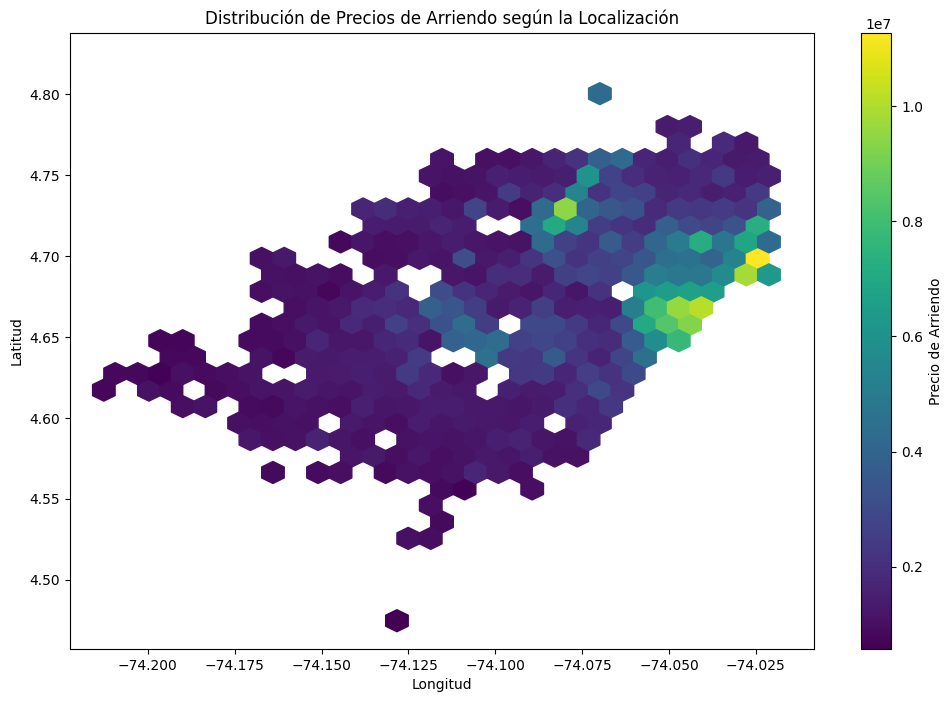

In [ ]:
plt.figure(figsize=(12, 8))
plt.hexbin(df['longitud'], df['latitud'], C=df['precio_arriendo'], gridsize=30, cmap='viridis', mincnt=1)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución de Precios de Arriendo según la Localización')
plt.colorbar(label='Precio de Arriendo')
plt.show()

Conclusiones

1.  La zona con mayores precios de arriendo (áreas en amarillo) se encuentra hacia la parte noreste del mapa, sugiriendo que las propiedades en estas ubicaciones tienen un mayor valor. Esto podría corresponder a sectores con alta demanda, mejor infraestructura o servicios, o bien a áreas de estrato socioeconómico más alto.

2.  Las áreas con precios más bajos se concentran en la parte suroeste, donde predominan los colores púrpura oscuro. Esto indica que en estas zonas las propiedades son más accesibles en términos de costo de arriendo, posiblemente debido a factores como menor desarrollo urbano o baja demanda.

3. En la parte central, se observan tanto hexágonos de precios medios como algunos de precios altos y bajos, lo que sugiere una mayor diversidad en la oferta de arriendos. Este fenómeno puede estar relacionado con una mezcla de propiedades de distintos niveles socioeconómicos y características dentro de un área relativamente cercana.

4. Dado que las zonas de mayor precio coinciden con las áreas de alta concentración de estratos altos observadas en la gráfica anterior (como Chapinero y Usaquén), se puede inferir que las propiedades en estas áreas están relacionadas con una mayor demanda de seguridad, calidad y accesibilidad a servicios, lo que incrementa el precio de arriendo.

En conclusión, la distribución geográfica sugiere una diferenciación clara en los precios de arriendo según la localización, con áreas de alta demanda y altos precios concentradas en el noreste, y zonas más accesibles en el suroeste.

¿Existen patrones en la distribución de viviendas que cuentan con jacuzzi, chimenea, o características de lujo en la ciudad?



In [ ]:
# Filtrar los datos para viviendas con jacuzzi
df_jacuzzi = df[df['jacuzzi'] == 1]

# Obtener las coordenadas de las viviendas con jacuzzi
jacuzzi_coords = df_jacuzzi[['latitud', 'longitud']].dropna().values.tolist()

# Crear el mapa de Bogotá
bogota_map = folium.Map(location=[4.6097, -74.0817], zoom_start=12)

# Agregar el mapa de calor al mapa de Bogotá para las viviendas con jacuzzi
HeatMap(jacuzzi_coords).add_to(bogota_map)

# Mostrar el mapa
bogota_map

In [ ]:
# Filtrar los datos para viviendas con chimenea
df_chimenea = df[df['piscina'] == 1]

# Obtener las coordenadas de las viviendas con chimenea
chimenea_coords = df_chimenea[['latitud', 'longitud']].dropna().values.tolist()

# Crear el mapa de Bogotá
bogota_map = folium.Map(location=[4.6097, -74.0817], zoom_start=12)

# Agregar el mapa de calor al mapa de Bogotá para las viviendas con chimenea
HeatMap(chimenea_coords).add_to(bogota_map)

# Mostrar el mapa
bogota_map

In [ ]:
# Filtrar los datos para viviendas con gimnasio
df_gimnasio = df[df['gimnasio'] == 1]

# Obtener las coordenadas de las viviendas con gimnasio
gimnasio_coords = df_gimnasio[['latitud', 'longitud']].dropna().values.tolist()

# Crear el mapa de Bogotá
bogota_map = folium.Map(location=[4.6097, -74.0817], zoom_start=12)

# Agregar el mapa de calor al mapa de Bogotá para las viviendas con gimnasio
HeatMap(gimnasio_coords).add_to(bogota_map)

# Mostrar el mapa
bogota_map

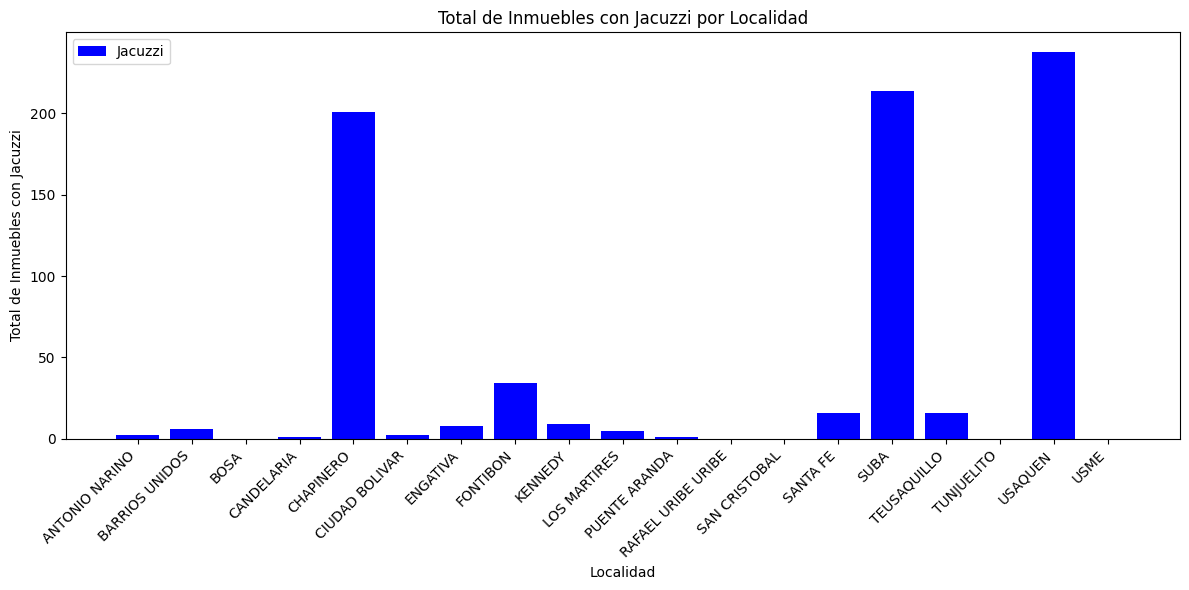

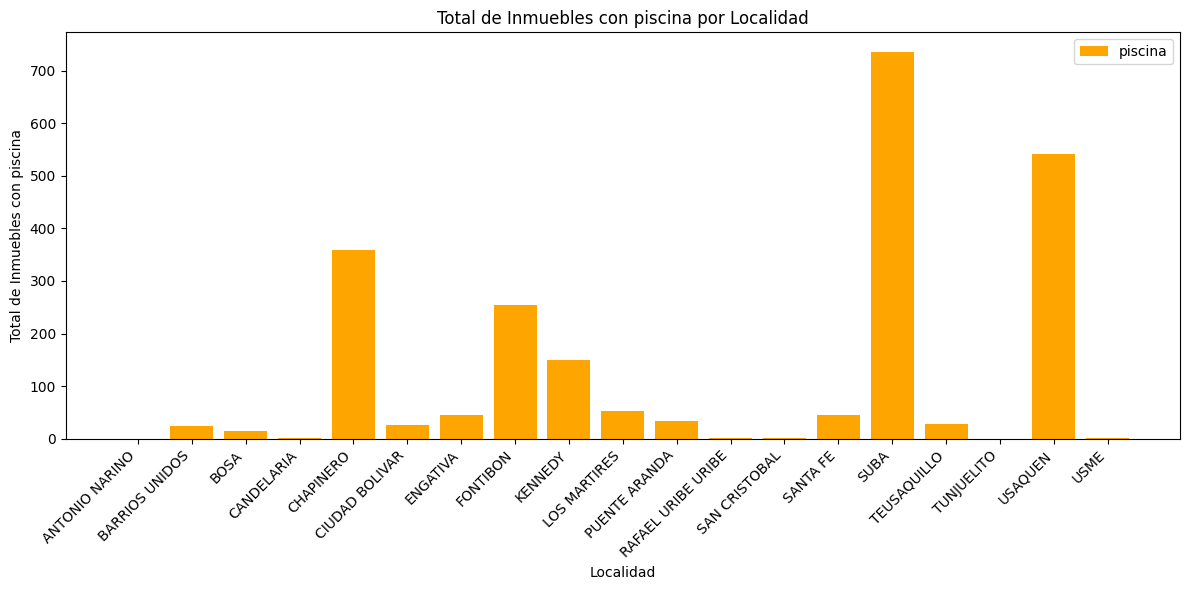

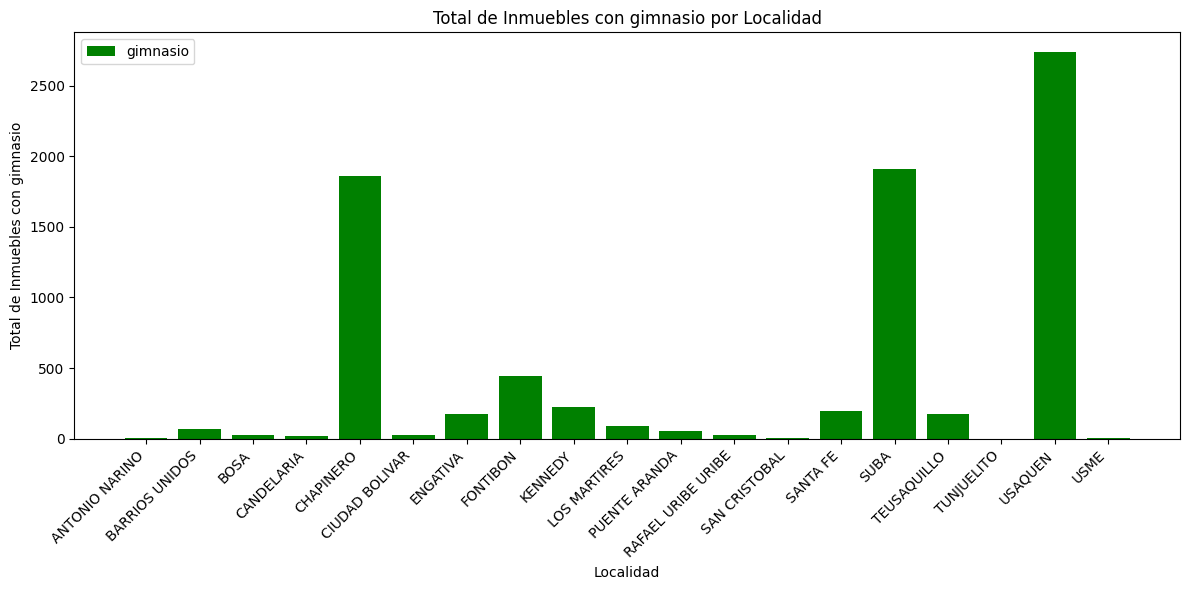

In [ ]:
# Agrupar por localidad y contar el número de inmuebles con jacuzzi y piscina
jacuzzi_por_localidad = df.groupby('localidad')['jacuzzi'].sum()
piscina_por_localidad = df.groupby('localidad')['piscina'].sum()
gimnasio_por_localidad = df.groupby('localidad')['gimnasio'].sum()

# Crear el gráfico de barras para Jacuzzi
plt.figure(figsize=(12, 6))
plt.bar(jacuzzi_por_localidad.index, jacuzzi_por_localidad.values, color='blue', label='Jacuzzi')
plt.xlabel('Localidad')
plt.ylabel('Total de Inmuebles con Jacuzzi')
plt.title('Total de Inmuebles con Jacuzzi por Localidad')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Crear el gráfico de barras para piscina
plt.figure(figsize=(12, 6))
plt.bar(piscina_por_localidad.index, piscina_por_localidad.values, color='orange', label='piscina')
plt.xlabel('Localidad')
plt.ylabel('Total de Inmuebles con piscina')
plt.title('Total de Inmuebles con piscina por Localidad')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Crear el gráfico de barras para piscina
plt.figure(figsize=(12, 6))
plt.bar(gimnasio_por_localidad.index, gimnasio_por_localidad.values, color='green', label='gimnasio')
plt.xlabel('Localidad')
plt.ylabel('Total de Inmuebles con gimnasio')
plt.title('Total de Inmuebles con gimnasio por Localidad')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Conclusiones

1.  Se observa una alta concentración de inmuebles con jacuzzi en las localidades de Chapinero, Suba y Usaquén. Estas áreas suelen ser consideradas de mayor nivel socioeconómico y probablemente atraen a un mercado que busca comodidades y características de lujo. La popularidad del jacuzzi en estas localidades sugiere una tendencia en la oferta de viviendas de lujo.

2. La presencia de piscinas es alta en Teusaquillo, Suba, Usaquén, y Chapinero. Esto también indica que las localidades con mayor nivel socioeconómico tienden a ofrecer más servicios y comodidades adicionales, como piscinas en sus propiedades, que generalmente están asociadas a conjuntos residenciales de alto costo o propiedades de lujo.

los patrones muestran que las viviendas con características de lujo (como jacuzzi, piscina y gimnasio) se concentran en localidades de estratos socioeconómicos altos. Esto sugiere que la demanda y oferta de comodidades de lujo está alineada con áreas que suelen tener precios de propiedad más elevados y una mayor capacidad adquisitiva.

¿Dónde se concentran los precios de administración más altos y cómo se relacionan con el estrato y los servicios ofrecidos en la vivienda?

La correlación entre el estrato y el precio de administración es: 0.6816084929214393


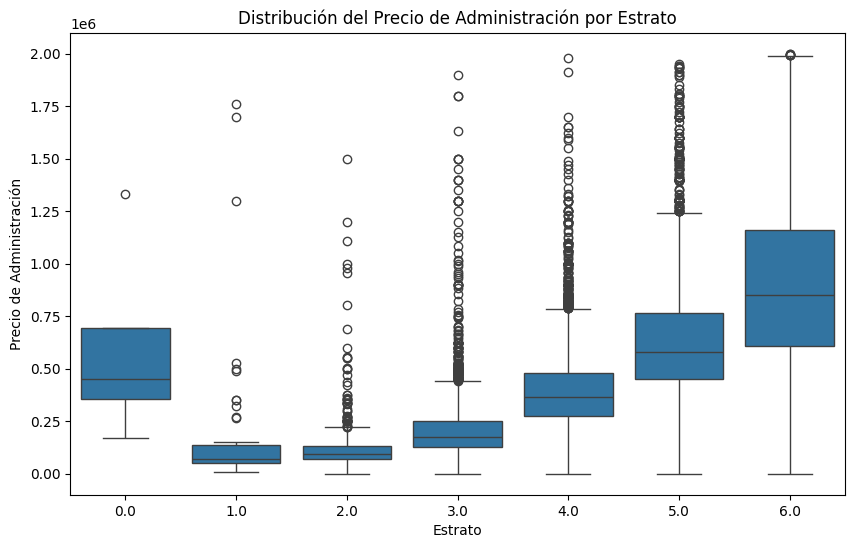

In [ ]:
# Calcular la correlación entre el estrato y el precio de administración
correlation = df['estrato'].corr(df['administracion'])
print(f"La correlación entre el estrato y el precio de administración es: {correlation}")

# Crear un gráfico de caja para visualizar la distribución del precio de administración por estrato
plt.figure(figsize=(10, 6))
sns.boxplot(x='estrato', y='administracion', data=df)
plt.xlabel('Estrato')
plt.ylabel('Precio de Administración')
plt.title('Distribución del Precio de Administración por Estrato')
plt.show()

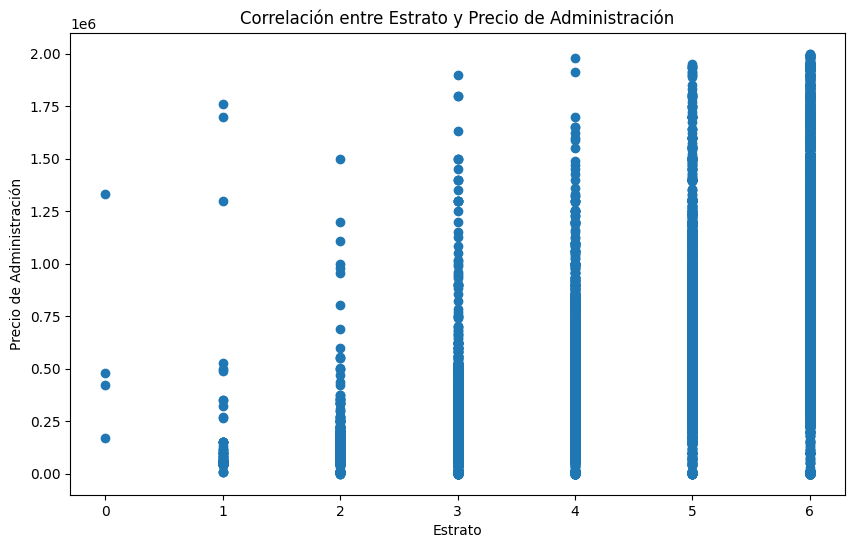

In [ ]:
# Crear un gráfico de dispersión para visualizar la relación entre el estrato y el precio de administración
plt.figure(figsize=(10, 6))
plt.scatter(df['estrato'], df['administracion'])
plt.xlabel('Estrato')
plt.ylabel('Precio de Administración')
plt.title('Correlación entre Estrato y Precio de Administración')
plt.show()

Conclusión


En el grafico los precios de administración más altos se concentran en los estratos superiores, específicamente en el estrato 6, seguido del estrato 5, donde los valores más altos de precio de administración suelen estar asociados con estratos más altos, lo cual sugiere que las viviendas de estratos superiores tienden a tener precios de administración más elevados.

Esto puede estar relacionado con los servicios ofrecidos en las viviendas de estos estratos, ya que los conjuntos residenciales en estos niveles generalmente incluyen servicios adicionales (como vigilancia, mantenimiento, áreas comunes más amplias, zonas recreativas, y otros beneficios) que aumentan el costo de administración. En contraste, los estratos más bajos muestran una menor variabilidad y precios de administración más bajos, lo que podría indicar una menor oferta de servicios adicionales. La correlación positiva de 0.68 refuerza esta relación entre estrato y precio de administración, sugiriendo que, a medida que aumenta el estrato, también lo hace el precio de administración, posiblemente debido a los servicios y beneficios adicionales ofrecidos.